In [2]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import time

import torch
import scipy.sparse
from torch import Tensor
from torch.utils.dlpack import to_dlpack, from_dlpack

import torch_geometric.data
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.utils import is_undirected, to_undirected

from pgmpy.estimators.CITests import chi_square
from scipy.special import softmax



In [3]:
G1 = nx.Graph()
G1.add_nodes_from([1, 2, 3])
G1.add_edges_from([(1, 2), (1, 3), (2, 3)])
print(G1)

Graph with 3 nodes and 3 edges


In [3]:
list(G1.edges)

[(1, 2), (1, 3), (2, 3)]

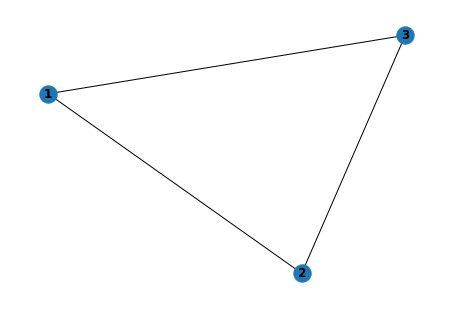

In [4]:
nx.draw(G1, with_labels=True, font_weight='bold')

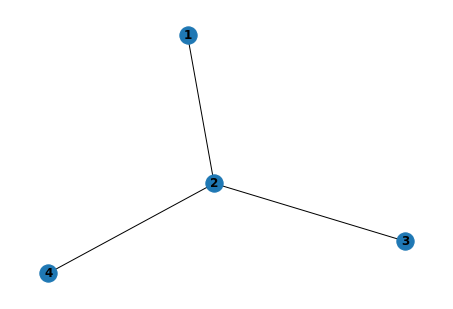

In [5]:
G2 = nx.Graph()
G2.add_nodes_from([1, 2, 3, 4])
G2.add_edges_from([(1, 2), (2, 3), (2, 4)])
nx.draw(G2, with_labels=True, font_weight='bold')

In [7]:
g_int = nx.intersection(G1, G2)

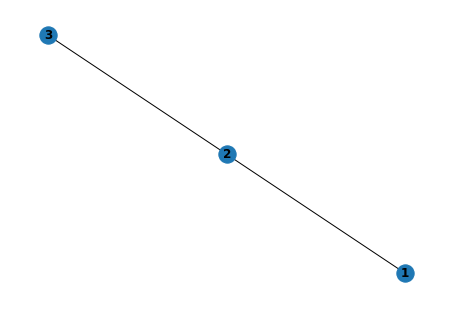

In [8]:
g_int.remove_nodes_from(list(nx.isolates(g_int)))
nx.draw(g_int, with_labels=True, font_weight='bold')


In [9]:
n_tp = g_int.number_of_edges()
n_tp

2

In [10]:
n_fp = len(G1.edges() - g_int.edges())
n_fp

1

In [11]:
n_fn = len(G2.edges() - g_int.edges())
n_fn

1

In [12]:
G2.edges() - g_int.edges()

{(2, 4)}

In [13]:
precision = n_tp / (n_tp + n_fp)
recall = n_tp / (n_tp + n_fn)
f1_score = 2*(precision * recall)/(precision + recall)
f1_score

0.6666666666666666

In [14]:
nx.graph_edit_distance(G1, G2)

3.0

In [7]:
def ba(n, m, role_start=0):
    G = nx.barabasi_albert_graph(n, m)
    labels = [role_start for i in range(n)]
    return G, labels


def house(start, role_start=1):
    """Builds a house-like  graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    OUTPUT:
    -------------
    graph       :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    """
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + 5))
    graph.add_edges_from(
        [
            (start, start + 1),
            (start + 1, start + 2),
            (start + 2, start + 3),
            (start + 3, start),
        ]
    )
    graph.add_edges_from([(start + 4, start), (start + 4, start + 1)])
    roles = [role_start, role_start, role_start + 1, role_start + 1, role_start + 2]
    return graph, roles


def build_ba_shapes(n_basis, n_shapes, rdm_basis_plugins=True, rdm_shape_plugins=True, pos=3, add_random_edges=0, m=5):
    # where you will plugin the houses
    # Sample (with replacement) where to attach the new motifs
    if rdm_basis_plugins is True:
        plugins = np.random.choice(n_basis, n_shapes, replace=False)
    else:
        spacing = math.floor(n_basis / n_shapes)
        plugins = [int(k * spacing) for k in range(n_shapes)]

    basis, role_id = ba(n_basis, m)
    start = n_basis
    for shape_id in range(n_shapes):
        graph_s, role_graph_s = house(start)
        n_s = nx.number_of_nodes(graph_s)
        basis.add_nodes_from(graph_s.nodes())
        basis.add_edges_from(graph_s.edges())
        if rdm_shape_plugins is True:
            pos = np.random.choice(range(start, start+n_s))
        basis.add_edges_from([(pos, plugins[shape_id])])
        role_id += role_graph_s
        start += n_s

    if add_random_edges > 0:
        # add random edges between nodes:
        n_rand = int(n_basis*add_random_edges)
        for p in range(n_rand):
            src, dest = np.random.choice(nx.number_of_nodes(basis), 2, replace=False)
            basis.add_edges_from([(src, dest)])
            
            
    # Add constant node features
    feat_dict = {i:{'feat': np.array([1], dtype=np.float32)} for i in basis.nodes()}
    nx.set_node_attributes(basis, feat_dict)
    
    # Convert graph into undirected graph
    basis = basis.to_undirected()

    return basis, role_id, plugins


In [8]:
n_basis, n_shapes = 2000, 200

G, labels, plugins = build_ba_shapes(n_basis, n_shapes)
#nx.draw(G, cmap=plt.get_cmap('viridis'), node_color=labels, with_labels=True, font_weight='bold')

In [9]:
plugins

array([1748,  577, 1584, 1135, 1778,  596,  734,  968, 1941,  877, 1332,
       1496, 1686,  485, 1003,  923, 1464, 1441,  160,  132, 1375, 1429,
       1418, 1700, 1336, 1447,  718,  887, 1629,   14, 1474, 1014,  351,
        109,  167, 1296, 1754,  163,  537,  478,  183,  989, 1551,  439,
       1681, 1698, 1275,  844, 1861,  627, 1723,  528, 1682, 1838,  837,
        446, 1611, 1489, 1708,   64,  135, 1745,  223,   68,  372,  320,
       1793, 1069, 1872,  309,  378,  592,  733, 1808, 1192,  561, 1411,
        880,  248,  173,  787, 1991,  333,  364,  976, 1600,  564,   29,
        124, 1363, 1389, 1858,  237, 1744,  623,  730, 1617,  698, 1985,
        434, 1425,  886,  188, 1021,  541,  464,  192, 1897, 1338,  824,
       1175,  775, 1146, 1076,   37,  490,  958, 1851, 1925,  884,   89,
       1191, 1151,  148, 1271,  335,  371, 1910, 1045, 1651,  694, 1200,
       1480,  558, 1145, 1260, 1416, 1138,  144,  779, 1233, 1950,  642,
       1141, 1350,   21, 1556,  410,  867,  337,  6

In [10]:
def preprocess_input_graph(G, labels, normalize_adj=False):
    """ Load an existing graph to be converted for the experiments.
    Args:
        G: Networkx graph to be loaded.
        labels: Associated node labels.
        normalize_adj: Should the method return a normalized adjacency matrix.
    Returns:
        A dictionary containing adjacency, node features and labels
    """
    adj = np.array(nx.to_numpy_matrix(G))
    if normalize_adj:
        sqrt_deg = np.diag(1.0 / np.sqrt(np.sum(adj, axis=0, dtype=float).squeeze()))
        adj = np.matmul(np.matmul(sqrt_deg, adj), sqrt_deg)

    existing_node = list(G.nodes)[-1]
    feat_dim = G.nodes[existing_node]["feat"].shape[0]
    f = np.zeros((G.number_of_nodes(), feat_dim), dtype=float)
    for i, u in enumerate(G.nodes()):
        f[i, :] = G.nodes[u]["feat"]

    # add batch dim
    #adj = np.expand_dims(adj, axis=0)
    #f = np.expand_dims(f, axis=0)
    #labels = np.expand_dims(labels, axis=0)
    return {"adj": adj, "feat": f, "labels": labels}

In [11]:
data = from_networkx(G, all)
data.edge_index.shape

/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/torch_geometric/utils/convert.py:164: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  data[key] = torch.tensor(value)


torch.Size([2, 22750])

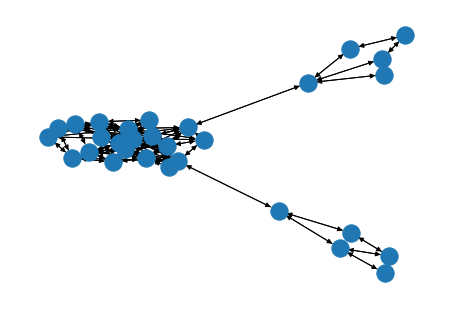

In [12]:
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
nx.draw(g)

In [12]:
data.num_node_features
data.num_classes = len(np.unique(labels))
data.y = torch.LongTensor(labels)

In [13]:
n = data.num_nodes
data.train_mask, data.val_mask, data.test_mask = torch.zeros(n, dtype=torch.uint8), torch.zeros(n, dtype=torch.uint8), torch.zeros(n, dtype=torch.uint8)

In [14]:
from sklearn.model_selection import train_test_split

train_ids, test_ids = train_test_split(range(n), test_size=0.2, random_state=42, shuffle=True)
train_ids, val_ids = train_test_split(train_ids, test_size=0.15, random_state=42, shuffle=True)

data.train_mask[train_ids] = 1
data.val_mask[val_ids] = 1
data.test_mask[test_ids] = 1

In [15]:
len(data.y[data.val_mask])

/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_35997/2781205052.py:1: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  len(data.y[data.val_mask])


360

In [12]:
nodes_sub, edge_index_sub, new_node_idx, edge_mask = k_hop_subgraph(32, 2, data.edge_index, relabel_nodes=True)
# nodes_sub is subset
# relabel_nodes changes edge_index indexation

In [13]:
new_node_idx

tensor([29])

In [41]:
mapping = {int(v): k for k, v in enumerate(subset)}
mapping

{1: 0, 30: 1, 31: 2, 32: 3, 33: 4, 34: 5}

In [40]:
nodes_sub

tensor([ 1, 30, 31, 32, 33, 34])

In [30]:
data.x[nodes_sub]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [26]:
#relabel_nodes is False
edge_index_sub

tensor([[ 1, 30, 30, 30, 31, 31, 31, 31, 32, 32, 33, 33, 34, 34],
        [31, 31, 33, 34,  1, 30, 32, 34, 31, 33, 30, 32, 30, 31]])

In [31]:
#relabel_nodes is True
edge_index_sub

tensor([[0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [2, 2, 4, 5, 0, 1, 3, 5, 2, 4, 1, 3, 1, 2]])

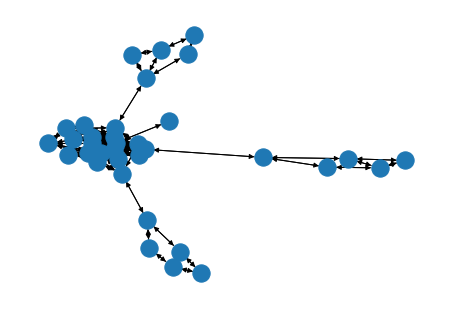

In [32]:
graph = to_networkx(data)
nx.draw(graph)

[32, 1, 33, 34, 30, 31]
[(32, 31), (32, 33), (1, 31), (33, 30), (33, 32), (34, 30), (34, 31), (30, 31), (30, 33), (30, 34), (31, 1), (31, 30), (31, 32), (31, 34)]


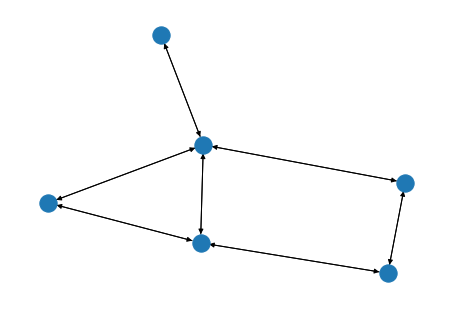

In [37]:
subset = nodes_sub
subgraph = graph.subgraph(subset.tolist())
nx.draw(subgraph)
print(subgraph.nodes())
print(subgraph.edges())

[0, 1, 2, 3, 4, 5]
[(0, 2), (1, 2), (1, 4), (1, 5), (2, 0), (2, 1), (2, 3), (2, 5), (3, 2), (3, 4), (4, 1), (4, 3), (5, 1), (5, 2)]


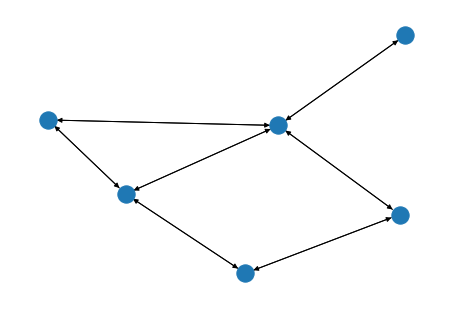

In [39]:
data_sub = Data(x=nodes_sub, edge_index=edge_index_sub)
subgraph = to_networkx(data_sub)
nx.draw(subgraph)
print(subgraph.nodes())
print(subgraph.edges())

In [177]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.num_layers = 2
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, data.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        
        return F.log_softmax(x, dim=1)

In [178]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_layers, hidden_dim):
        super().__init__()
        self.num_node_features, self.num_classes, self.num_layers, self.hidden_dim = num_node_features, num_classes, num_layers, hidden_dim
        self.layers = torch.nn.ModuleList()
        current_dim = self.num_node_features
        for l in range(self.num_layers - 1):
            self.layers.append(GCNConv(current_dim, hidden_dim))
            current_dim = hidden_dim
        self.layers.append(GCNConv(current_dim, self.num_classes))

    def forward(self, x, edge_index, edge_weight=None):
        for layer in self.layers[:-1]:
            x = layer(x, edge_index, edge_weight)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.layers[-1](x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1)


In [179]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR

n_epochs = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(data.num_node_features, data.num_classes, 2, 16).to(device)
data = data.to(device)
print(data)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
#scheduler = ReduceLROnPlateau(optimizer, 'min')
#scheduler = ExponentialLR(optimizer, gamma=0.99)
scheduler = StepLR(optimizer, step_size=100, gamma=0.99)

val_err = []
train_err = []
        

model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
    
    if epoch%10==0:
        val_err.append(val_loss.item())
        train_err.append(loss.item())
        
        
    loss.backward()
    optimizer.step()
    scheduler.step()
    #scheduler.step(val_loss)

Data(edge_index=[2, 22750], x=[3000, 1], num_classes=4, y=[3000], train_mask=[3000], val_mask=[3000], test_mask=[3000])


/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_35997/1776601654.py:24: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_35997/1776601654.py:25: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/torch/autograd/__init__.py:154: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  Variable._execution_engine.run_backward(


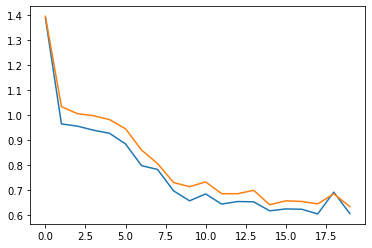

In [180]:
plt.plot(range(n_epochs//10), val_err)
plt.plot(range(n_epochs//10), train_err)

In [181]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8050


/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_35997/1796556738.py:3: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()


In [182]:
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
acc = int(correct) / int(data.train_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7936


/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_35997/3035444030.py:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()


In [330]:
pred = model(data.x, data.edge_index).argmax(dim=1)
list_node_idx = np.where(pred == data.y)[0]
list_node_idx_house = list_node_idx[list_node_idx>n_basis]
test_nodes = [x.item() for x in random.choices(list_node_idx_house, k=10)]

In [56]:
edge_mask[indices] = torch.FloatTensor([1]*num_top_edges)
explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, y = data.y, threshold=0.99)

NameError: name 'num_top_edges' is not defined

In [353]:
from sklearn import metrics


def get_explanation(data, edge_mask, num_top_edges=6, is_hard_mask=False):
    if is_hard_mask:
        explanation = data.edge_index[:, np.where(edge_mask == 1)[0]]
    else:
        indices = (-edge_mask).argsort()[:num_top_edges]
        explanation = data.edge_index[:, indices]

    G_expl = nx.Graph()
    G_expl.add_nodes_from(np.unique(explanation))

    for i, (u, v) in enumerate(explanation.t().tolist()):
        G_expl.add_edge(u, v)

    return (G_expl)

def get_ground_truth_ba_shapes(node, data):
    base = [0, 1, 2, 3, 4]
    offset = node % 5
    ground_truth = [node - offset + val for val in base]
    start = ground_truth[0]
    graph, role = house(start, role_start=1)

    true_node_mask = np.zeros(data.edge_index.shape[1])
    true_node_mask[ground_truth] = 1
    true_edge_mask = node_attr_to_edge(data.edge_index, true_node_mask)

    return graph, role, true_edge_mask


def get_scores(G1, G2):
    g_int = nx.intersection(G1, G2)
    g_int.remove_nodes_from(list(nx.isolates(g_int)))

    n_tp = g_int.number_of_edges()
    n_fp = len(G1.edges() - g_int.edges())
    n_fn = len(G2.edges() - g_int.edges())

    precision = n_tp / (n_tp + n_fp)
    recall = n_tp / (n_tp + n_fn)
    if n_tp == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    ged = nx.graph_edit_distance(G1, G2)

    return recall, precision, f1_score, ged



In [358]:
def eval_accuracy(data, edge_masks, list_node_idx, num_top_edges, is_hard_mask=False):
    n_test = len(list_node_idx)
    scores = []
    
    for i in range(n_test):
    
        edge_mask = torch.Tensor(edge_masks[i])
        node_idx = list_node_idx[i]
        entry = get_accuracy(data, edge_mask, node_idx, num_top_edges, is_hard_mask)
        scores.append(entry)
        
    scores = list_to_dict(scores)
    accuracy_scores = {k:np.mean(v) for k,v in scores.items()}
    return(accuracy_scores)


def get_accuracy(data, edge_mask, node_idx, num_top_edges, is_hard_mask=False):
    G_true, role, true_edge_mask = get_ground_truth_ba_shapes(node_idx, data)
    # nx.draw(G_true, cmap=plt.get_cmap('viridis'), node_color=role, with_labels=True, font_weight='bold')
    G_expl = get_explanation(data, edge_mask, num_top_edges, is_hard_mask=is_hard_mask)
    plt.figure()
    nx.draw(G_expl,  with_labels=True, font_weight='bold')
    plt.show()
    plt.clf()
    recall, precision, f1_score, ged = get_scores(G_expl, G_true)
    fpr, tpr, thresholds = metrics.roc_curve(true_edge_mask, edge_mask, pos_label=2)
    auc = metrics.auc(fpr, tpr)
    return {'recall':recall, 'precision':precision, 'f1_score':f1_score, 'ged':ged, 'auc':auc}

[2700, 2441, 2036, 2741, 2010, 2436, 2845, 2831, 2515, 2026, 2086, 2470, 2586, 2501, 2331, 2941, 2736, 2405, 2996, 2560, 2986, 2660, 2531, 2746, 2071, 2016, 2356, 2156, 2670, 2116, 2616, 2160, 2060, 2811, 2261, 2551, 2586, 2150, 2640, 2591, 2075, 2830, 2711, 2310, 2115, 2521, 2796, 2541, 2380, 2741, 2420, 2270, 2896, 2315, 2471, 2356, 2096, 2856, 2456, 2706, 2015, 2146, 2731, 2276, 2726, 2096, 2006, 2285, 2711, 2481, 2991, 2085, 2230, 2100, 2631, 2386, 2926, 2170, 2961, 2816, 2421, 2786, 2410, 2106, 2920, 2905, 2605, 2331, 2035, 2260, 2731, 2511, 2050, 2601, 2625, 2441, 2980, 2155, 2941, 2726, 2686, 2190, 2505, 2420, 2580, 2590, 2785, 2581, 2030, 2915, 2966, 2665, 2750, 2176, 2415, 2595, 2471, 2240, 2146, 2871, 2960, 2745, 2356, 2096, 2085, 2765, 2260, 2445, 2565, 2380, 2376, 2505, 2290, 2361, 2031, 2086, 2941, 2731, 2281, 2571, 2611, 2715, 2456, 2495, 2540, 2580, 2585, 2251, 2046, 2190, 2725, 2231, 2870, 2460, 2131, 2956, 2020, 2796, 2681, 2035, 2145, 2935, 2450, 2366, 2631, 2485, 234

Explain node 2700: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 433.84it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.37880546
0.37880546


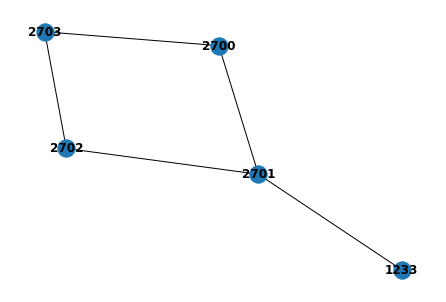

f1_score, ged 0.7272727272727272 1.0
<class 'int'>


Explain node 2441: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 440.22it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.28427312
0.28427312


<Figure size 432x288 with 0 Axes>

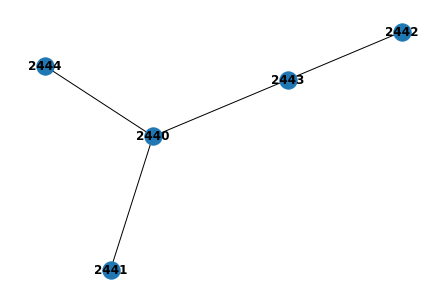

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2036: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 433.69it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.17737885
0.17737885


<Figure size 432x288 with 0 Axes>

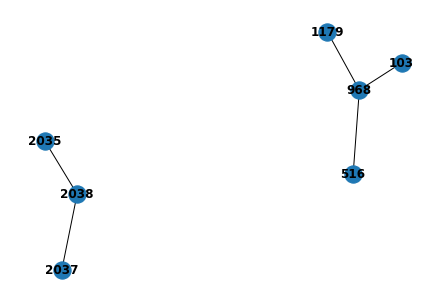

f1_score, ged 0.3636363636363636 7.0
<class 'int'>


Explain node 2741: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 452.72it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.11518757
0.11518757


<Figure size 432x288 with 0 Axes>

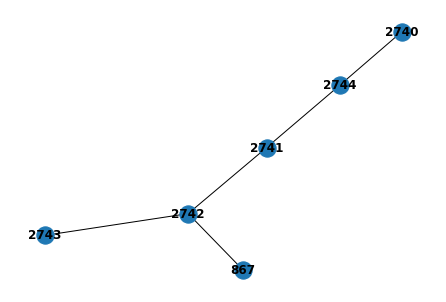

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2010: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 468.06it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3078017
0.3078017


<Figure size 432x288 with 0 Axes>

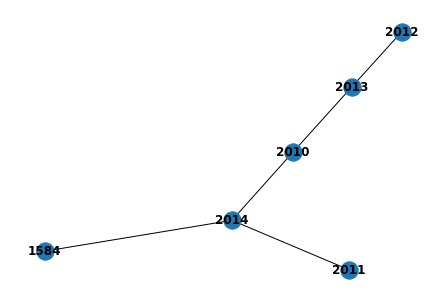

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2436: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 491.06it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.37390542
0.37390542


<Figure size 432x288 with 0 Axes>

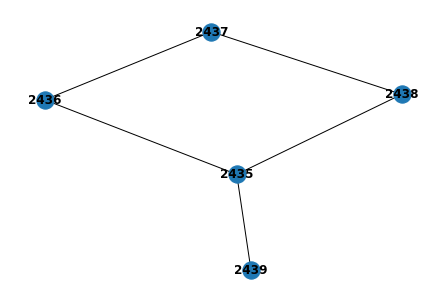

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2845: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 479.42it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.319736
0.319736


<Figure size 432x288 with 0 Axes>

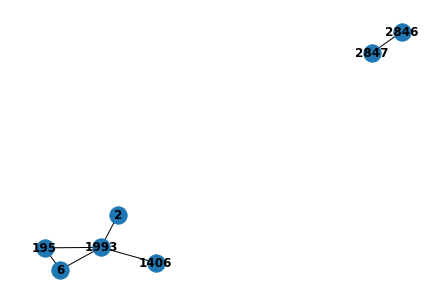

f1_score, ged 0.16666666666666666 6.0
<class 'int'>


Explain node 2831: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 518.57it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.43188632
0.43188632


<Figure size 432x288 with 0 Axes>

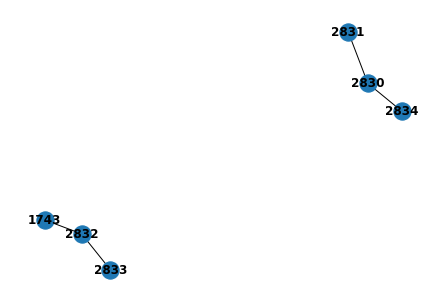

f1_score, ged 0.6 5.0
<class 'int'>


Explain node 2515: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 514.48it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.22972624
0.22972624


<Figure size 432x288 with 0 Axes>

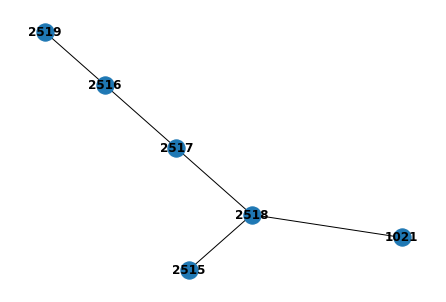

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2026: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 528.41it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.35204905
0.35204905


<Figure size 432x288 with 0 Axes>

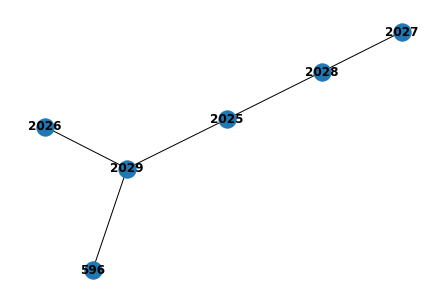

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2086: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 511.89it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.41213894
0.41213894


<Figure size 432x288 with 0 Axes>

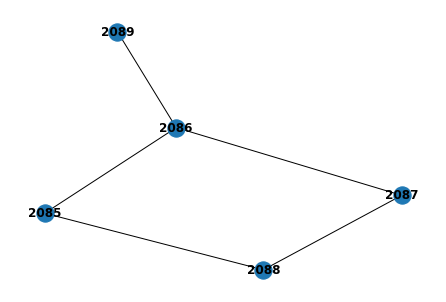

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2470: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 519.44it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.22207989
0.22207989


<Figure size 432x288 with 0 Axes>

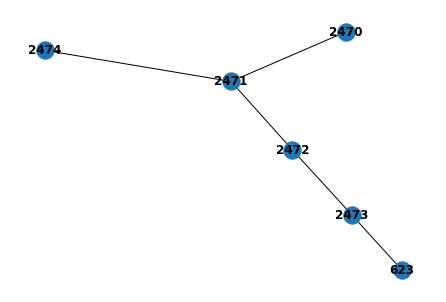

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2586: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 509.41it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3625937
0.3625937


<Figure size 432x288 with 0 Axes>

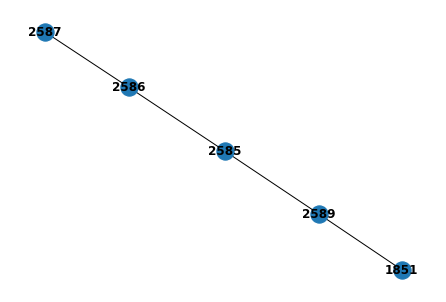

f1_score, ged 0.6 2.0
<class 'int'>


Explain node 2501: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 459.52it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.31170103
0.31170103


<Figure size 432x288 with 0 Axes>

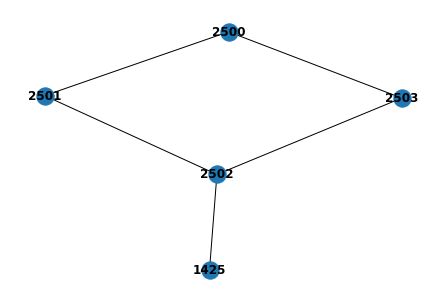

f1_score, ged 0.7272727272727272 1.0
<class 'int'>


Explain node 2331: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 488.77it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.27541482
0.27541482


<Figure size 432x288 with 0 Axes>

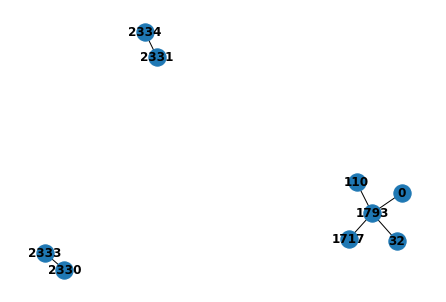

f1_score, ged 0.3333333333333333 10.0
<class 'int'>


Explain node 2941: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 496.48it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.38005653
0.38005653


<Figure size 432x288 with 0 Axes>

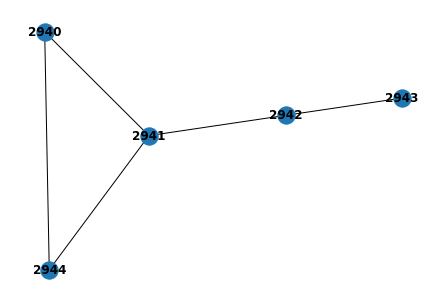

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2736: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 470.33it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.19447029
0.19447029


<Figure size 432x288 with 0 Axes>

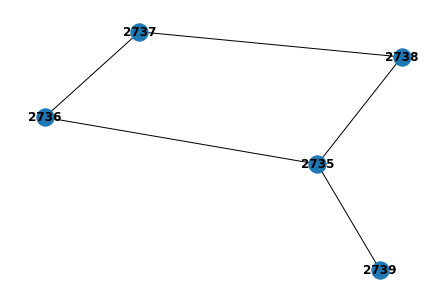

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2405: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 496.35it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.42033735
0.42033735


<Figure size 432x288 with 0 Axes>

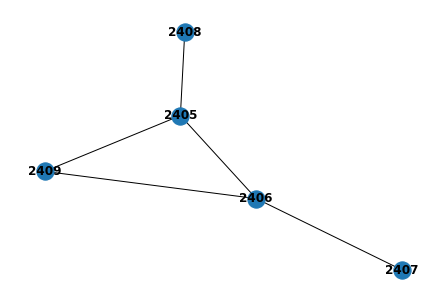

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2996: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 472.29it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.40554765
0.40554765


<Figure size 432x288 with 0 Axes>

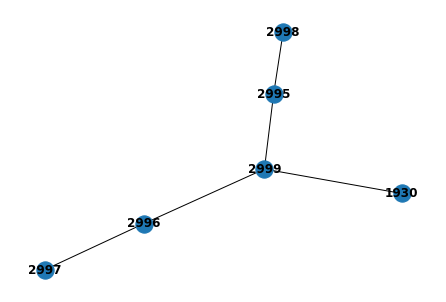

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2560: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 529.47it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36738208
0.36738208


<Figure size 432x288 with 0 Axes>

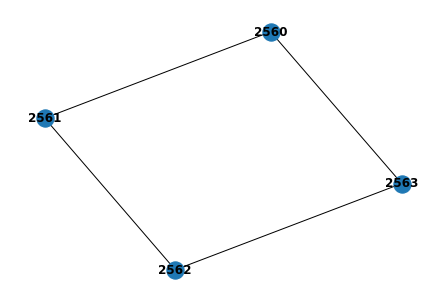

f1_score, ged 0.8 3.0
<class 'int'>


Explain node 2986: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 470.55it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.2659518
0.2659518


<Figure size 432x288 with 0 Axes>

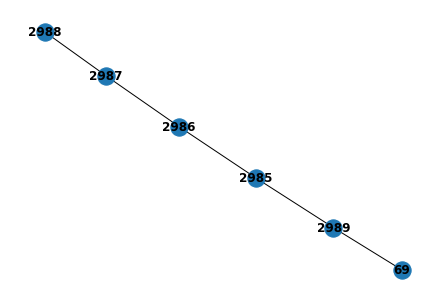

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2660: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 525.40it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.34227917
0.34227917


<Figure size 432x288 with 0 Axes>

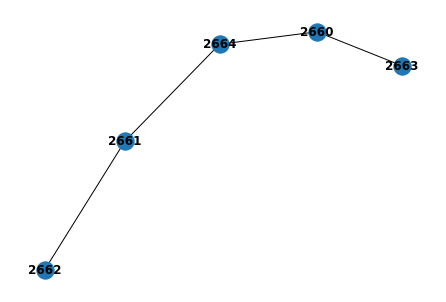

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2531: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 477.99it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3720589
0.3720589


<Figure size 432x288 with 0 Axes>

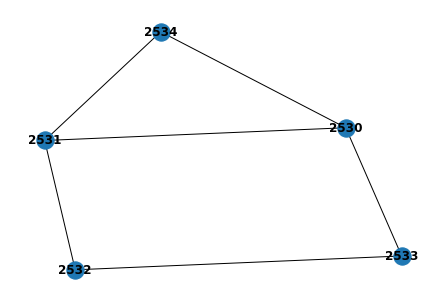

f1_score, ged 1.0 0.0
<class 'int'>


Explain node 2746: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 484.78it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.35601422
0.35601422


<Figure size 432x288 with 0 Axes>

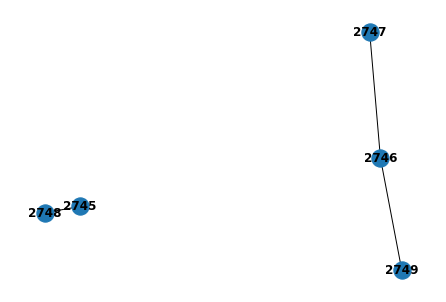

f1_score, ged 0.6666666666666666 3.0
<class 'int'>


Explain node 2071: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 462.89it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.41383767
0.41383767


<Figure size 432x288 with 0 Axes>

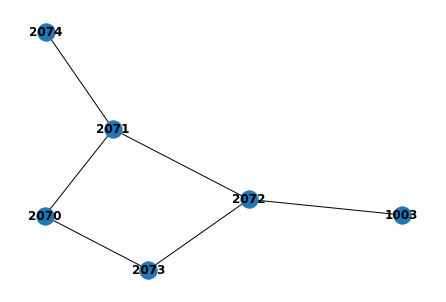

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2016: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 516.17it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.32722595
0.32722595


<Figure size 432x288 with 0 Axes>

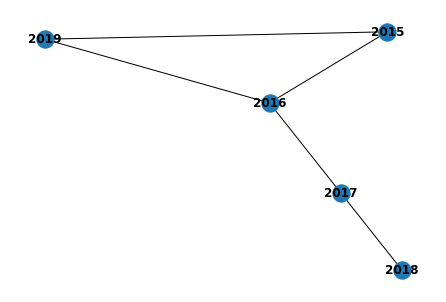

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2356: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 505.32it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.4328114
0.4328114


<Figure size 432x288 with 0 Axes>

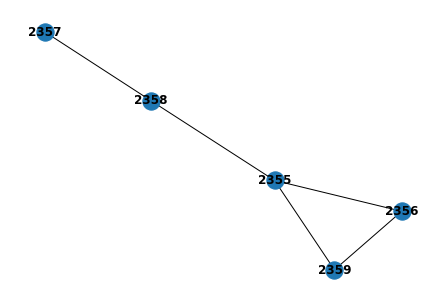

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2156: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 516.67it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.42663157
0.42663157


<Figure size 432x288 with 0 Axes>

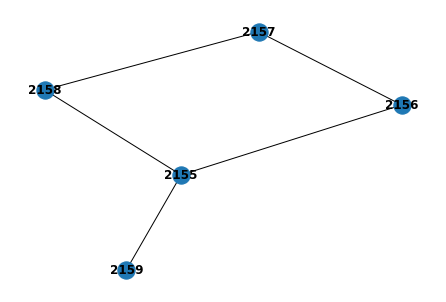

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2670: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 504.16it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.40148124
0.40148124


<Figure size 432x288 with 0 Axes>

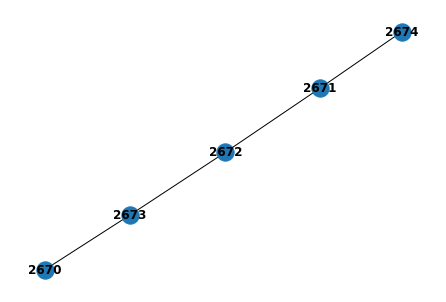

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2116: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 523.58it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.2821294
0.2821294


<Figure size 432x288 with 0 Axes>

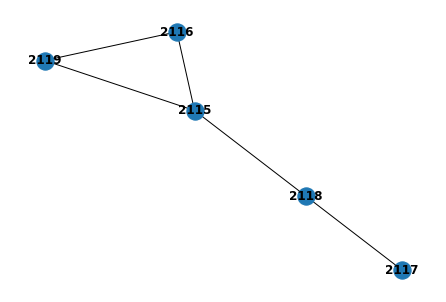

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2616: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 524.75it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.35932696
0.35932696


<Figure size 432x288 with 0 Axes>

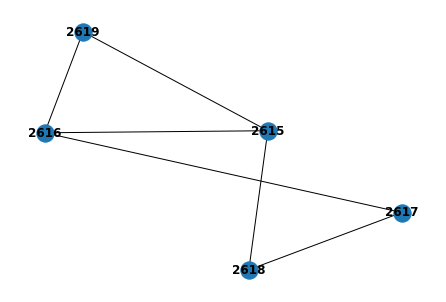

f1_score, ged 1.0 0.0
<class 'int'>


Explain node 2160: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 467.09it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.33769503
0.33769503


<Figure size 432x288 with 0 Axes>

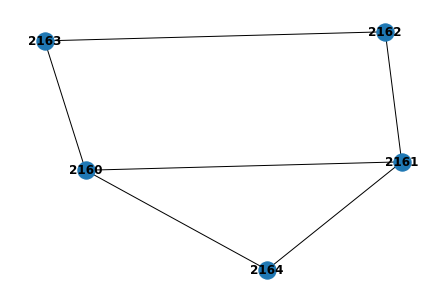

f1_score, ged 1.0 0.0
<class 'int'>


Explain node 2060: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 495.56it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3590573
0.3590573


<Figure size 432x288 with 0 Axes>

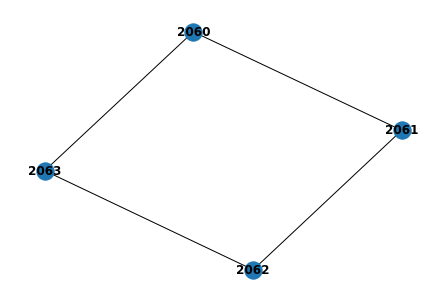

f1_score, ged 0.8 3.0
<class 'int'>


Explain node 2811: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 467.63it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36325562
0.36325562


<Figure size 432x288 with 0 Axes>

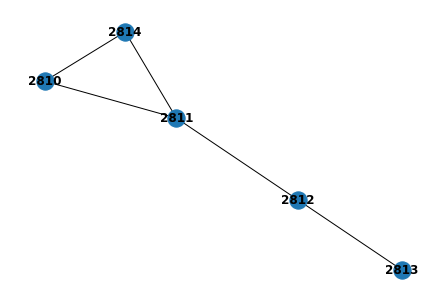

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2261: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 488.86it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.30725735
0.30725735


<Figure size 432x288 with 0 Axes>

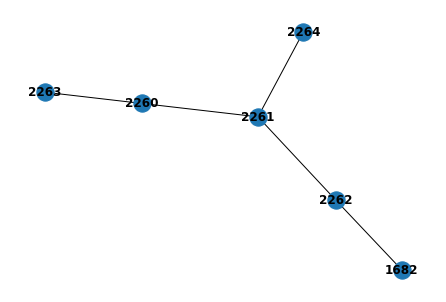

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2551: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 495.32it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.39842278
0.39842278


<Figure size 432x288 with 0 Axes>

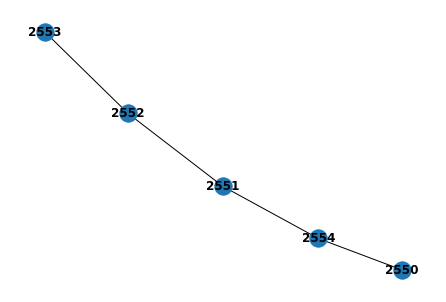

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2586: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 480.90it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3518093
0.3518093


<Figure size 432x288 with 0 Axes>

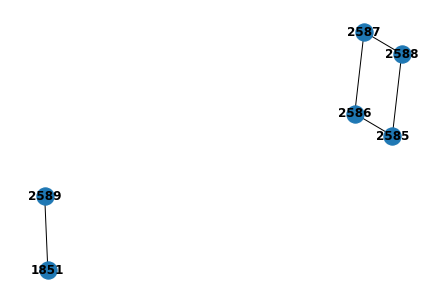

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2150: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 491.70it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.26946822
0.26946822


<Figure size 432x288 with 0 Axes>

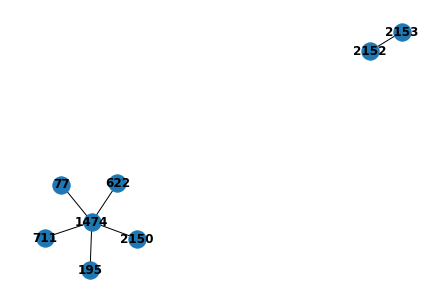

f1_score, ged 0.16666666666666666 9.0
<class 'int'>


Explain node 2640: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 476.65it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.23008636
0.23008636


<Figure size 432x288 with 0 Axes>

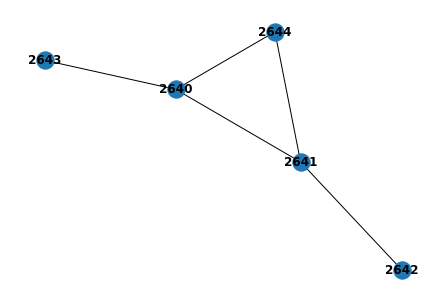

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2591: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 548.82it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.43815163
0.43815163


<Figure size 432x288 with 0 Axes>

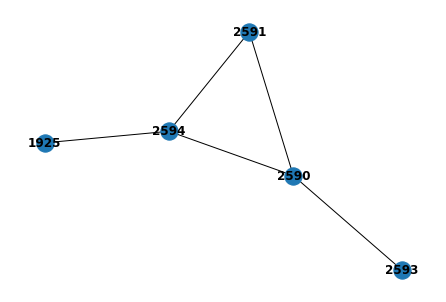

f1_score, ged 0.7272727272727272 1.0
<class 'int'>


Explain node 2075: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 545.76it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.311781
0.311781


<Figure size 432x288 with 0 Axes>

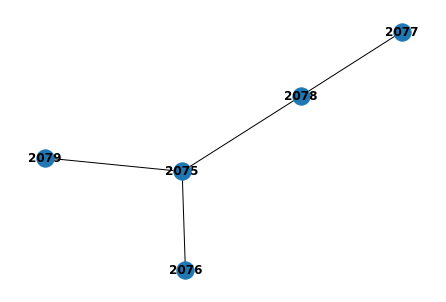

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2830: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 549.82it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.38369963
0.38369963


<Figure size 432x288 with 0 Axes>

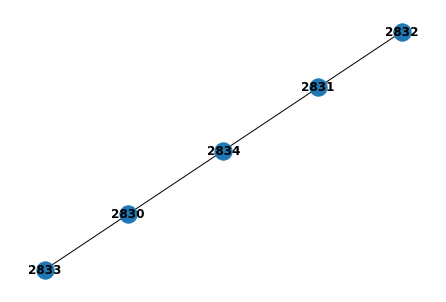

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2711: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 555.57it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.30029666
0.30029666


<Figure size 432x288 with 0 Axes>

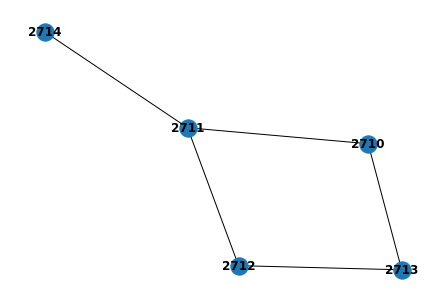

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2310: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 544.21it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.41955695
0.41955695


<Figure size 432x288 with 0 Axes>

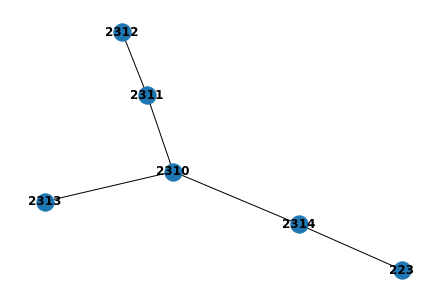

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2115: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 452.22it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.43043453
0.43043453


<Figure size 432x288 with 0 Axes>

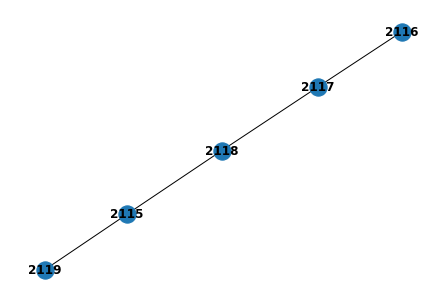

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2521: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 454.62it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.24955045
0.24955045


<Figure size 432x288 with 0 Axes>

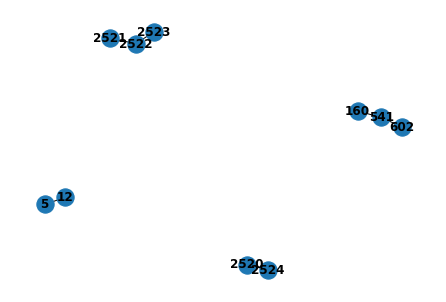

f1_score, ged 0.5 11.0
<class 'int'>


Explain node 2796: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 451.47it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.41538578
0.41538578


<Figure size 432x288 with 0 Axes>

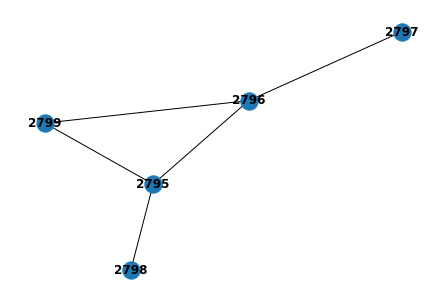

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2541: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 472.99it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3724918
0.3724918


<Figure size 432x288 with 0 Axes>

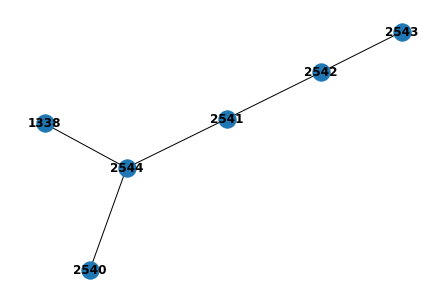

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2380: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 421.43it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.17971697
0.17971697


<Figure size 432x288 with 0 Axes>

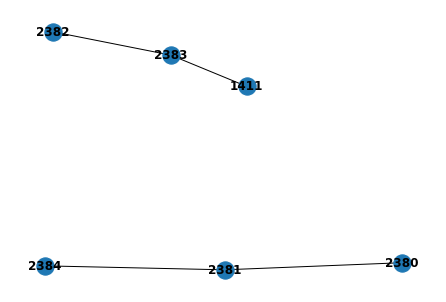

f1_score, ged 0.6 5.0
<class 'int'>


Explain node 2741: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 417.31it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.4070236
0.4070236


<Figure size 432x288 with 0 Axes>

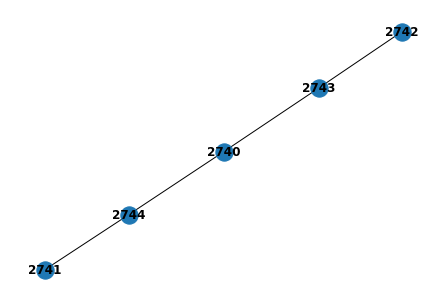

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2420: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 503.59it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.31695017
0.31695017


<Figure size 432x288 with 0 Axes>

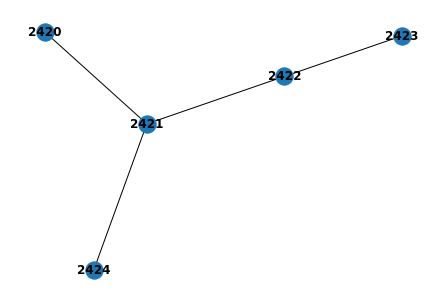

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2270: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 481.11it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.31541485
0.31541485


<Figure size 432x288 with 0 Axes>

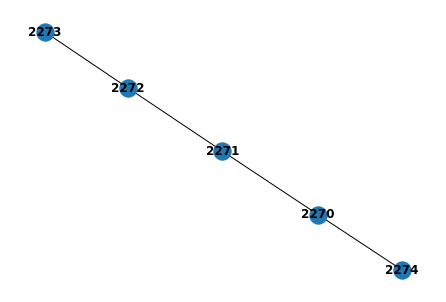

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2896: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 468.56it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.29462507
0.29462507


<Figure size 432x288 with 0 Axes>

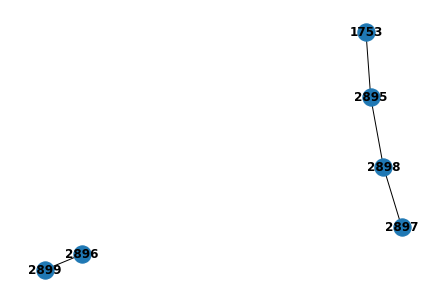

f1_score, ged 0.6 5.0
<class 'int'>


Explain node 2315: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 476.74it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.2615664
0.2615664


<Figure size 432x288 with 0 Axes>

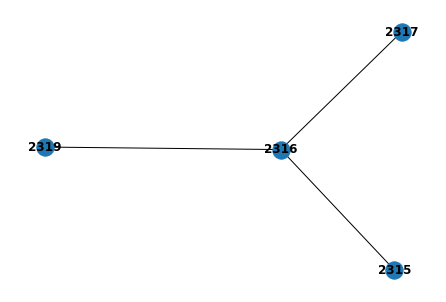

f1_score, ged 0.6666666666666666 4.0
<class 'int'>


Explain node 2471: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 484.12it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3001491
0.3001491


<Figure size 432x288 with 0 Axes>

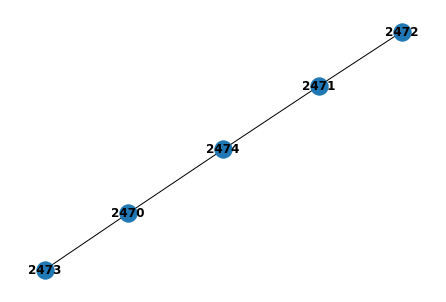

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2356: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 505.55it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.41855446
0.41855446


<Figure size 432x288 with 0 Axes>

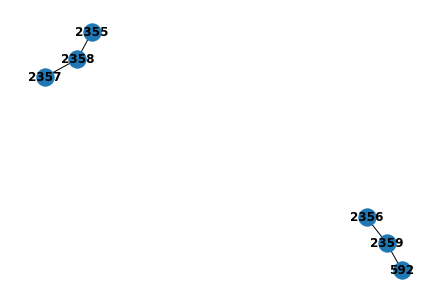

f1_score, ged 0.6 5.0
<class 'int'>


Explain node 2096: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 540.68it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.37375715
0.37375715


<Figure size 432x288 with 0 Axes>

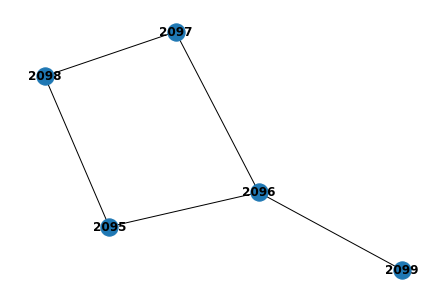

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2856: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 488.62it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.35726818
0.35726818


<Figure size 432x288 with 0 Axes>

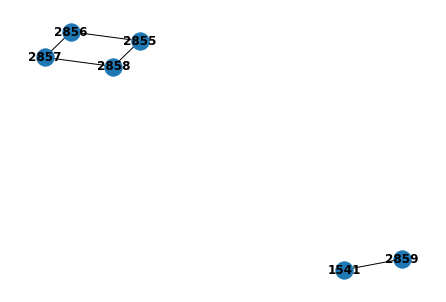

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2456: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 449.80it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.34178543
0.34178543


<Figure size 432x288 with 0 Axes>

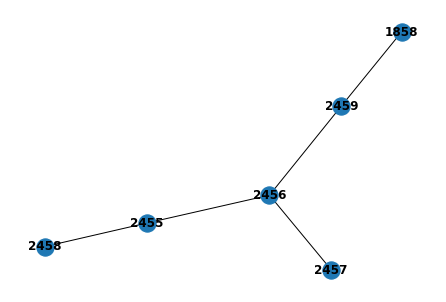

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2706: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 478.87it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.19307567
0.19307567


<Figure size 432x288 with 0 Axes>

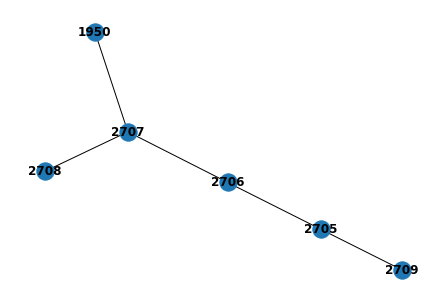

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2015: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 258.68it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.4285521
0.4285521


<Figure size 432x288 with 0 Axes>

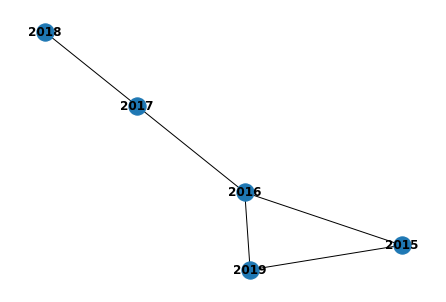

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2146: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 526.50it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.2547007
0.2547007


<Figure size 432x288 with 0 Axes>

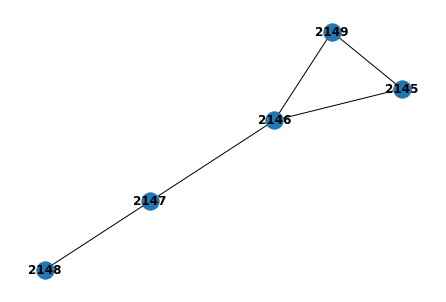

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2731: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 532.17it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.27646846
0.27646846


<Figure size 432x288 with 0 Axes>

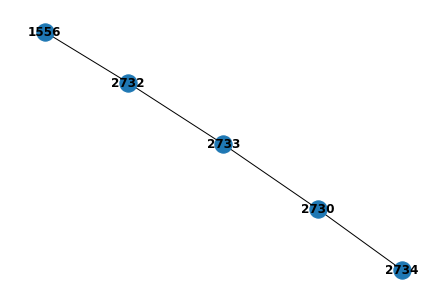

f1_score, ged 0.6 2.0
<class 'int'>


Explain node 2276: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 556.20it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.081011645
0.081011645


<Figure size 432x288 with 0 Axes>

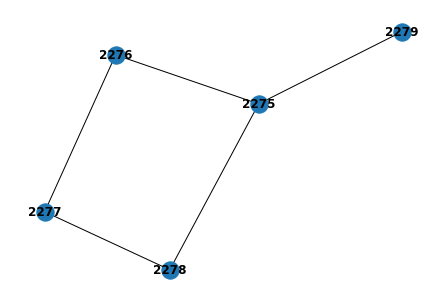

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2726: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 521.52it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.27769014
0.27769014


<Figure size 432x288 with 0 Axes>

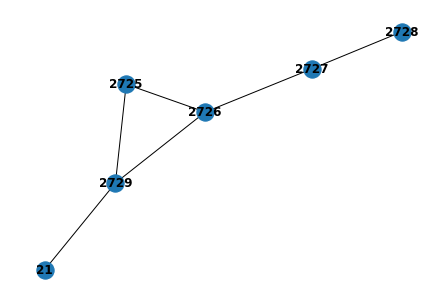

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2096: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 495.69it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3438032
0.3438032


<Figure size 432x288 with 0 Axes>

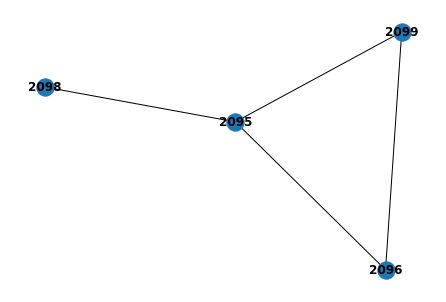

f1_score, ged 0.8 3.0
<class 'int'>


Explain node 2006: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 497.23it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.2579856
0.2579856


<Figure size 432x288 with 0 Axes>

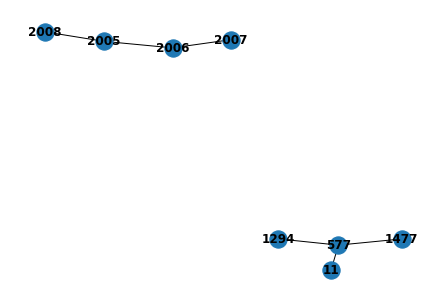

f1_score, ged 0.5 9.0
<class 'int'>


Explain node 2285: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 399.30it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.42231363
0.42231363


<Figure size 432x288 with 0 Axes>

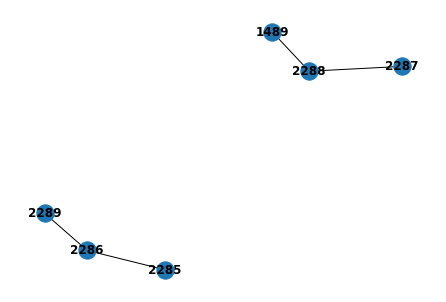

f1_score, ged 0.6 5.0
<class 'int'>


Explain node 2711: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 464.89it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.32234135
0.32234135


<Figure size 432x288 with 0 Axes>

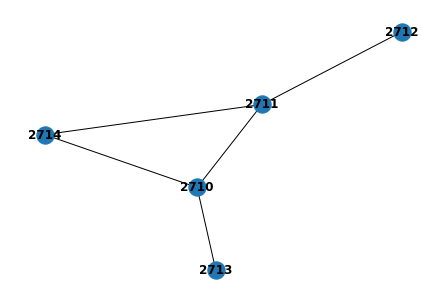

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2481: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 480.38it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.40408674
0.40408674


<Figure size 432x288 with 0 Axes>

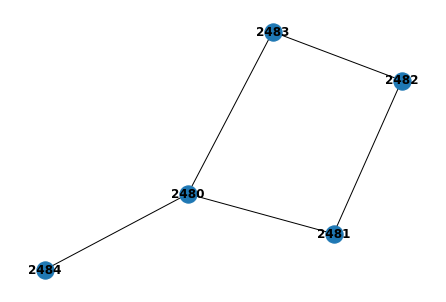

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2991: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 343.10it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.23589538
0.23589538


<Figure size 432x288 with 0 Axes>

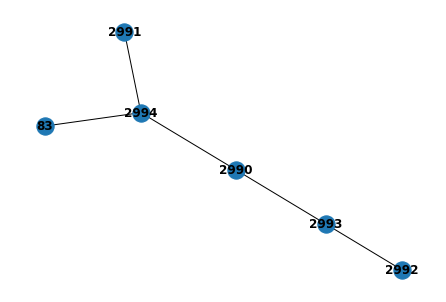

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2085: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 468.23it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.25813597
0.25813597


<Figure size 432x288 with 0 Axes>

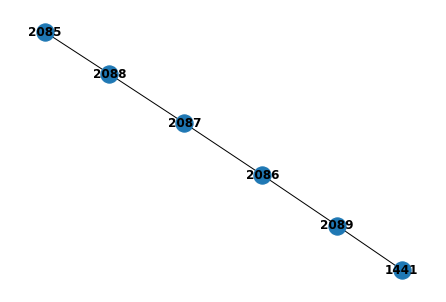

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2230: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 540.02it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.420083
0.420083


<Figure size 432x288 with 0 Axes>

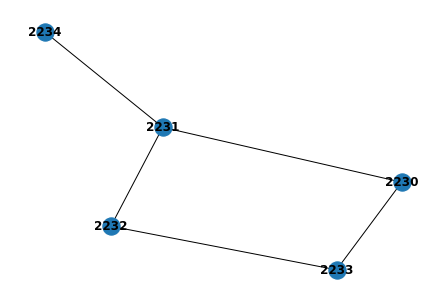

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 471.93it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.14098267
0.14098267


<Figure size 432x288 with 0 Axes>

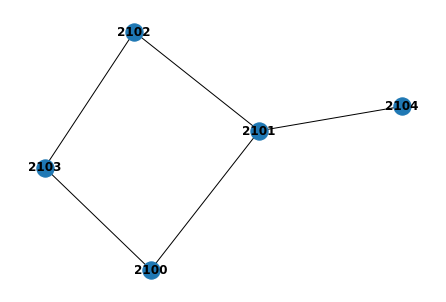

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2631: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 436.47it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.40242457
0.40242457


<Figure size 432x288 with 0 Axes>

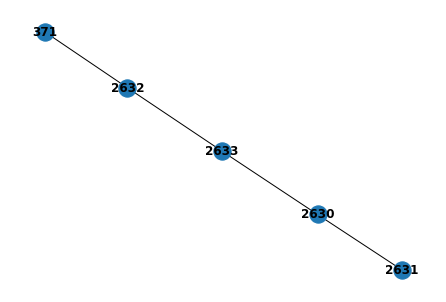

f1_score, ged 0.6 2.0
<class 'int'>


Explain node 2386: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 511.40it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.41391343
0.41391343


<Figure size 432x288 with 0 Axes>

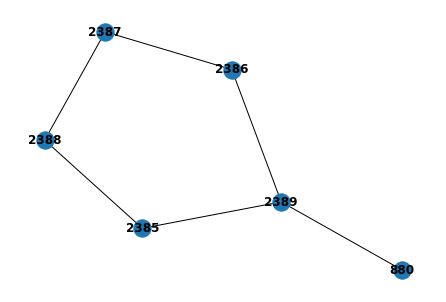

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2926: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 565.59it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.4357644
0.4357644


<Figure size 432x288 with 0 Axes>

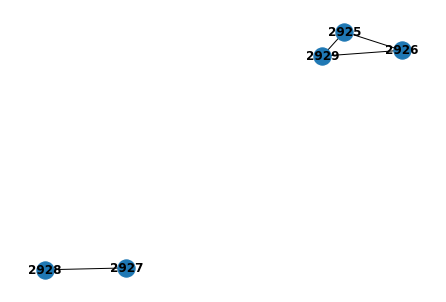

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2170: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 517.28it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36758876
0.36758876


<Figure size 432x288 with 0 Axes>

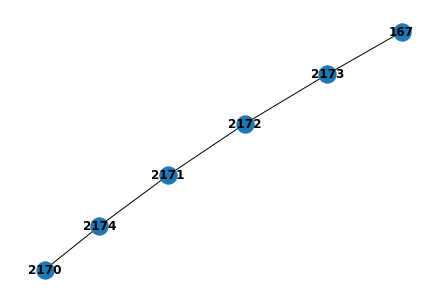

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2961: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 551.04it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.09505058
0.09505058


<Figure size 432x288 with 0 Axes>

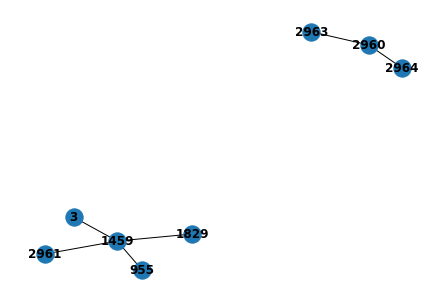

f1_score, ged 0.3333333333333333 9.0
<class 'int'>


Explain node 2816: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 537.63it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3468231
0.3468231


<Figure size 432x288 with 0 Axes>

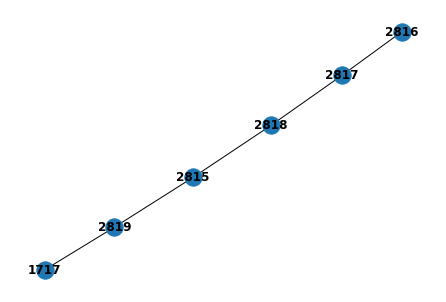

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2421: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 504.66it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.33247483
0.33247483


<Figure size 432x288 with 0 Axes>

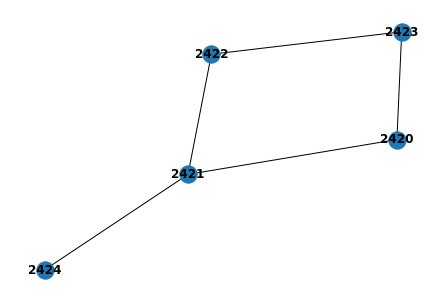

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2786: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 533.13it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.2857708
0.2857708


<Figure size 432x288 with 0 Axes>

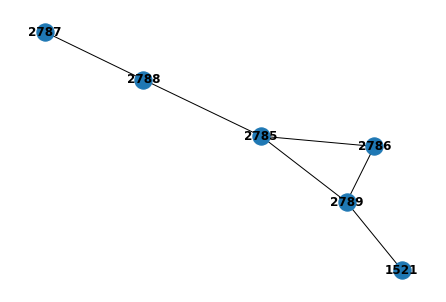

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2410: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 521.94it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.112440474
0.112440474


<Figure size 432x288 with 0 Axes>

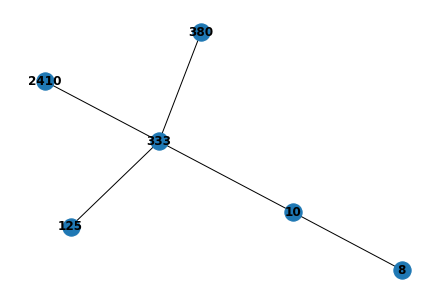

f1_score, ged 0 4.0
<class 'int'>


Explain node 2106: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 525.93it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.29828253
0.29828253


<Figure size 432x288 with 0 Axes>

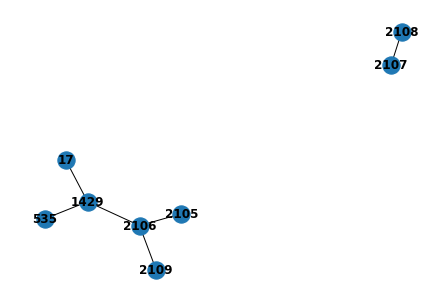

f1_score, ged 0.5 7.0
<class 'int'>


Explain node 2920: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 518.39it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.12387256
0.12387256


<Figure size 432x288 with 0 Axes>

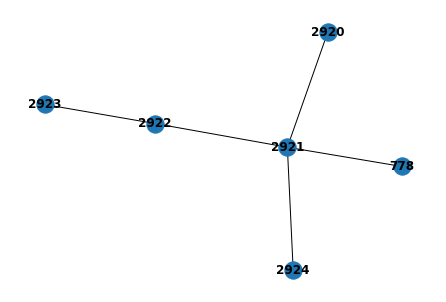

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2905: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 508.58it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.32941818
0.32941818


<Figure size 432x288 with 0 Axes>

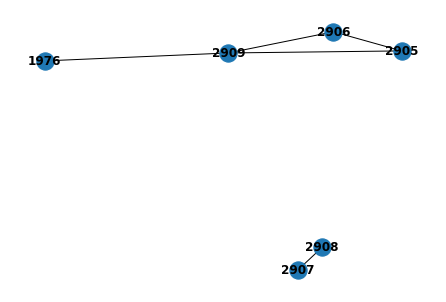

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2605: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 529.93it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.41046926
0.41046926


<Figure size 432x288 with 0 Axes>

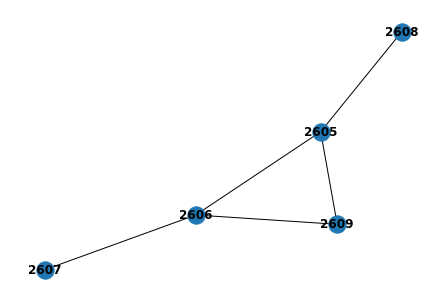

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2331: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 527.23it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.20860744
0.20860744


<Figure size 432x288 with 0 Axes>

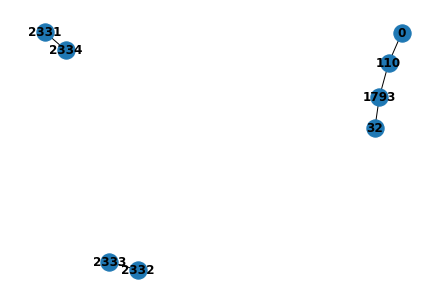

f1_score, ged 0.3636363636363636 8.0
<class 'int'>


Explain node 2035: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 552.47it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.40362424
0.40362424


<Figure size 432x288 with 0 Axes>

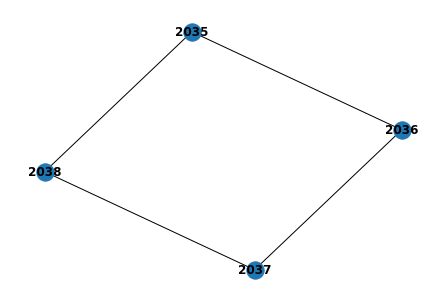

f1_score, ged 0.8 3.0
<class 'int'>


Explain node 2260: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 544.82it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.35967034
0.35967034


<Figure size 432x288 with 0 Axes>

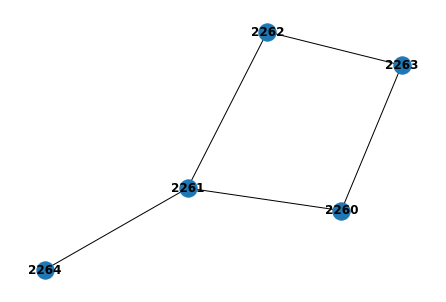

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2731: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 538.77it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.13267514
0.13267514


<Figure size 432x288 with 0 Axes>

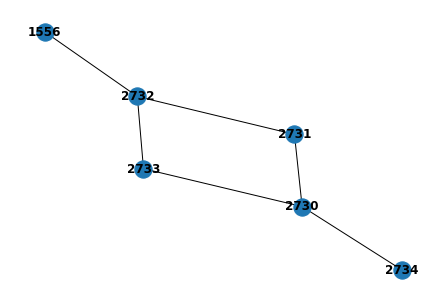

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2511: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 555.17it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.25001886
0.25001886


<Figure size 432x288 with 0 Axes>

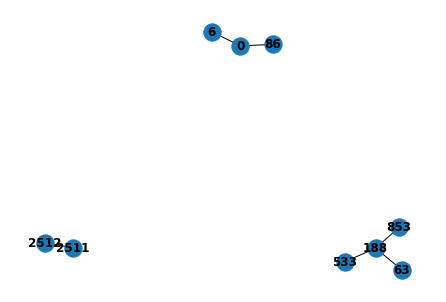

f1_score, ged 0.16666666666666666 10.0
<class 'int'>


Explain node 2050: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 560.10it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.09414648
0.09414648


<Figure size 432x288 with 0 Axes>

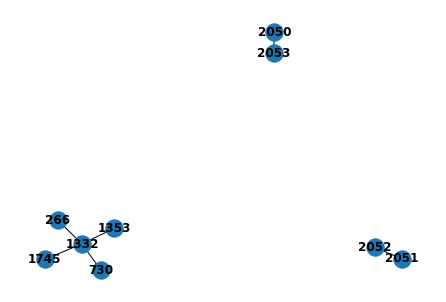

f1_score, ged 0.3333333333333333 10.0
<class 'int'>


Explain node 2601: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 562.81it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.056917485
0.056917485


<Figure size 432x288 with 0 Axes>

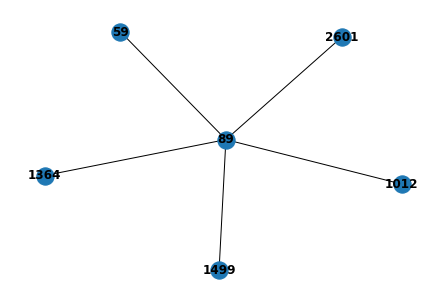

f1_score, ged 0 6.0
<class 'int'>


Explain node 2625: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 568.31it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.40603402
0.40603402


<Figure size 432x288 with 0 Axes>

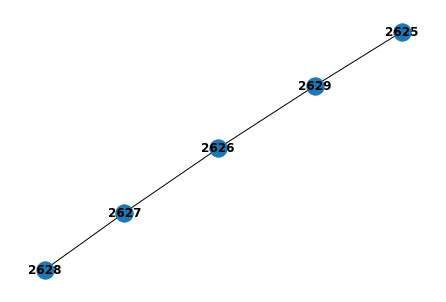

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2441: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 548.74it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.07035176
0.07035176


<Figure size 432x288 with 0 Axes>

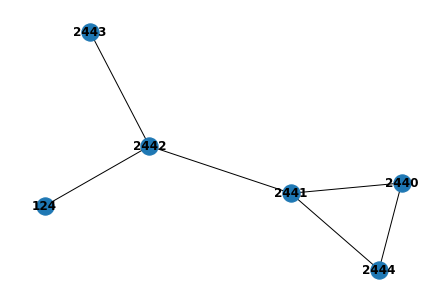

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2980: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 555.12it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.2956193
0.2956193


<Figure size 432x288 with 0 Axes>

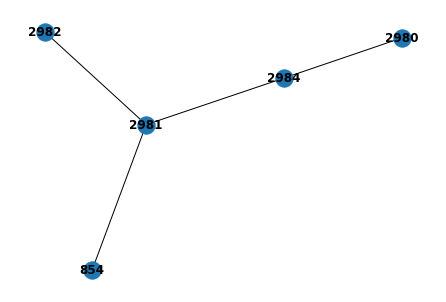

f1_score, ged 0.6 2.0
<class 'int'>


Explain node 2155: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 543.80it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.21994533
0.21994533


<Figure size 432x288 with 0 Axes>

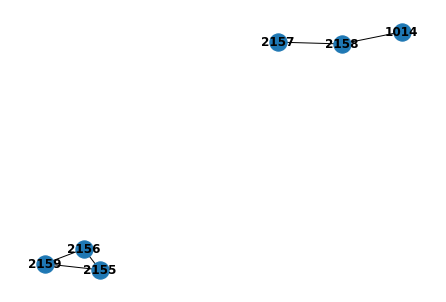

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2941: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 579.93it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.39634028
0.39634028


<Figure size 432x288 with 0 Axes>

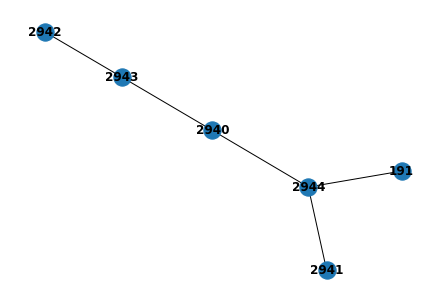

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2726: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 565.32it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.29989913
0.29989913


<Figure size 432x288 with 0 Axes>

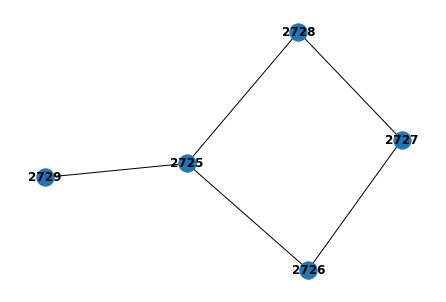

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2686: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 530.18it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.32302618
0.32302618


<Figure size 432x288 with 0 Axes>

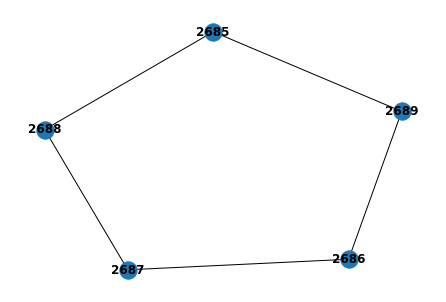

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2190: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 380.53it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.31903845
0.31903845


<Figure size 432x288 with 0 Axes>

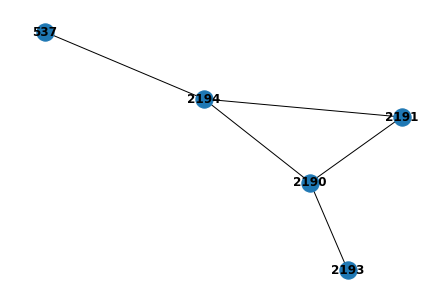

f1_score, ged 0.7272727272727272 1.0
<class 'int'>


Explain node 2505: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 552.32it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36267012
0.36267012


<Figure size 432x288 with 0 Axes>

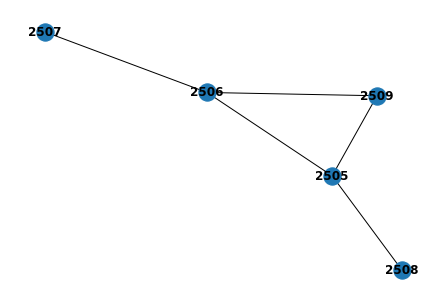

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2420: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 372.52it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.4038078
0.4038078


<Figure size 432x288 with 0 Axes>

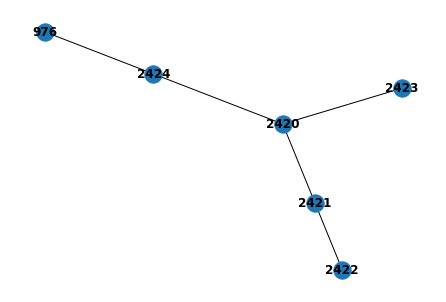

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2580: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 401.75it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3777332
0.3777332


<Figure size 432x288 with 0 Axes>

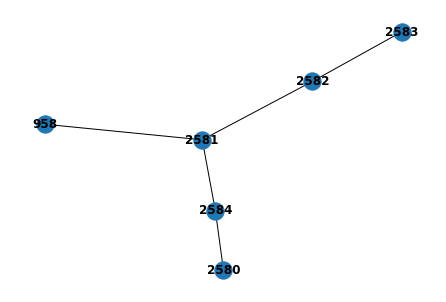

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2590: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 530.04it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.2129403
0.2129403


<Figure size 432x288 with 0 Axes>

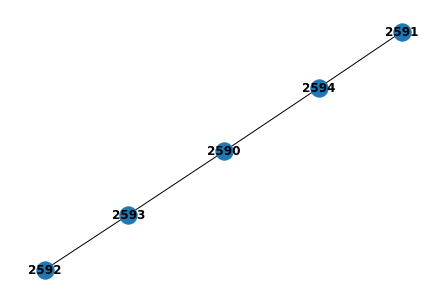

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2785: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 532.13it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.4286194
0.4286194


<Figure size 432x288 with 0 Axes>

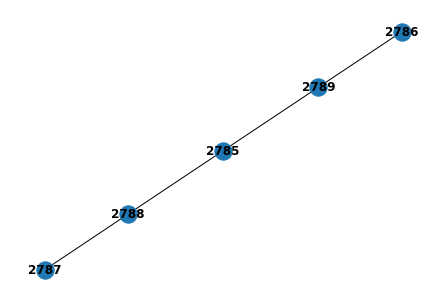

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2581: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 541.55it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.050457
0.050457


<Figure size 432x288 with 0 Axes>

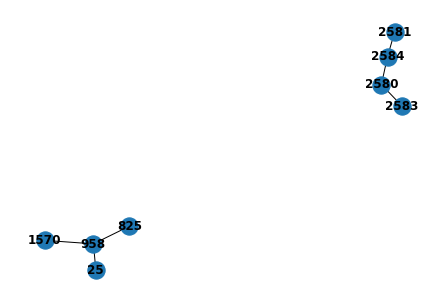

f1_score, ged 0.5 9.0
<class 'int'>


Explain node 2030: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 568.08it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.39324954
0.39324954


<Figure size 432x288 with 0 Axes>

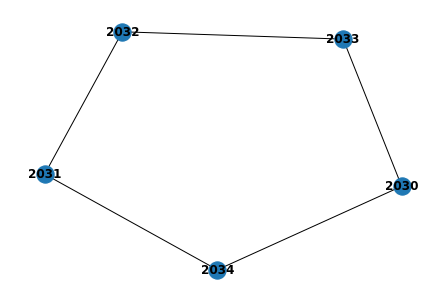

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2915: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 521.09it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.11588417
0.11588417


<Figure size 432x288 with 0 Axes>

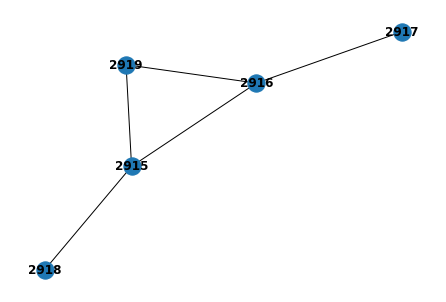

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2966: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 542.66it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.41476643
0.41476643


<Figure size 432x288 with 0 Axes>

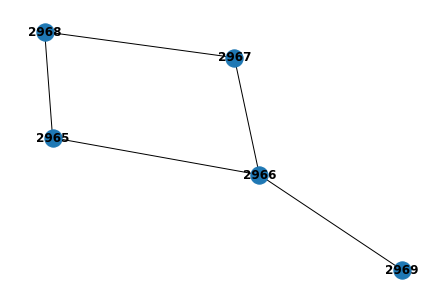

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2665: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 538.82it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.213827
0.213827


<Figure size 432x288 with 0 Axes>

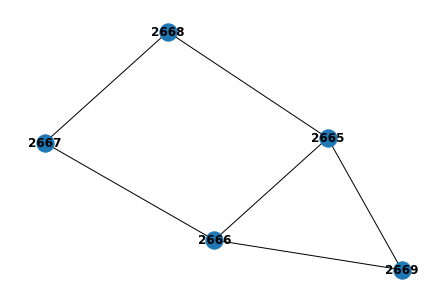

f1_score, ged 1.0 0.0
<class 'int'>


Explain node 2750: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 542.18it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.24406482
0.24406482


<Figure size 432x288 with 0 Axes>

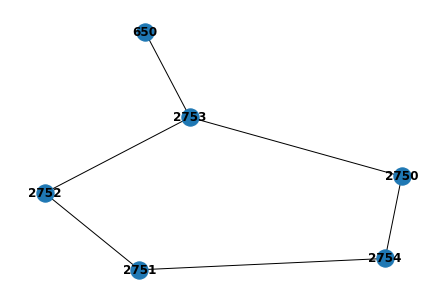

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2176: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 550.43it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3651845
0.3651845


<Figure size 432x288 with 0 Axes>

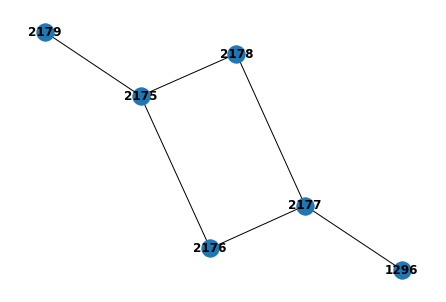

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2415: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 543.43it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.35511315
0.35511315


<Figure size 432x288 with 0 Axes>

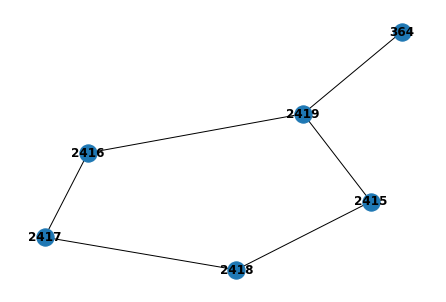

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2595: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 545.96it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.2892526
0.2892526


<Figure size 432x288 with 0 Axes>

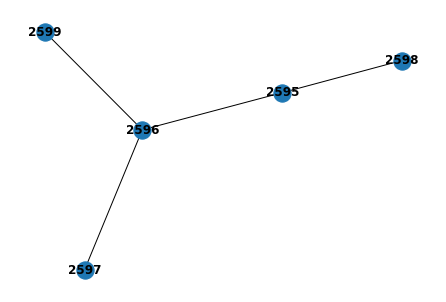

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2471: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 547.59it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.38789365
0.38789365


<Figure size 432x288 with 0 Axes>

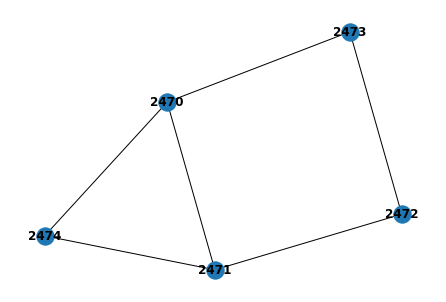

f1_score, ged 1.0 0.0
<class 'int'>


Explain node 2240: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 545.48it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.29517874
0.29517874


<Figure size 432x288 with 0 Axes>

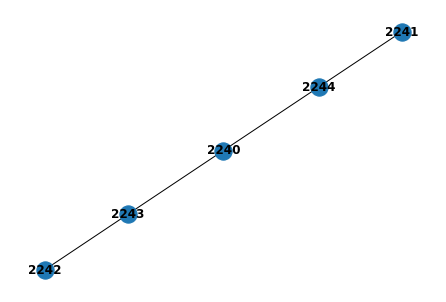

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2146: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 550.41it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.24824208
0.24824208


<Figure size 432x288 with 0 Axes>

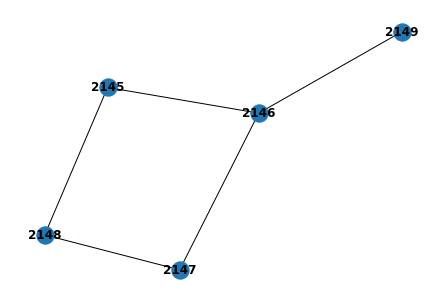

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2871: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 539.70it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3417998
0.3417998


<Figure size 432x288 with 0 Axes>

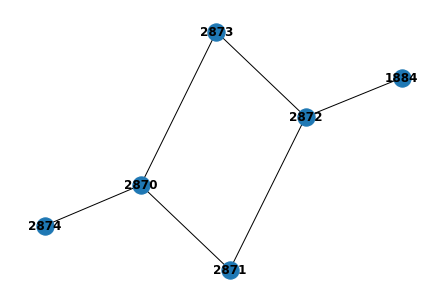

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2960: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 562.31it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.21322523
0.21322523


<Figure size 432x288 with 0 Axes>

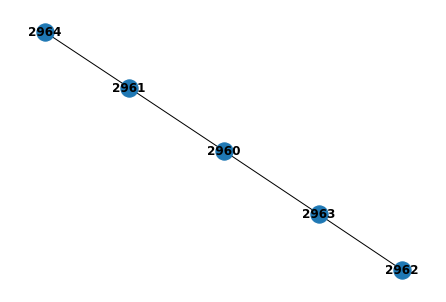

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2745: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 555.66it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.15876403
0.15876403


<Figure size 432x288 with 0 Axes>

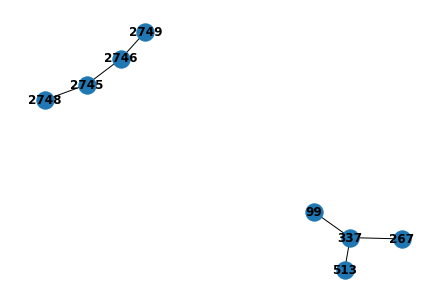

f1_score, ged 0.5 9.0
<class 'int'>


Explain node 2356: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 565.76it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.2581247
0.2581247


<Figure size 432x288 with 0 Axes>

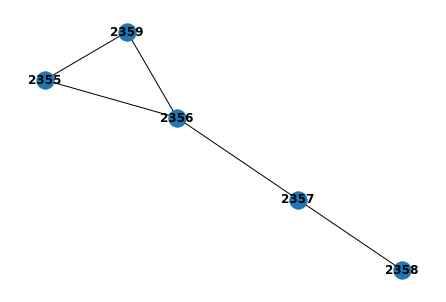

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2096: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 552.53it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3047428
0.3047428


<Figure size 432x288 with 0 Axes>

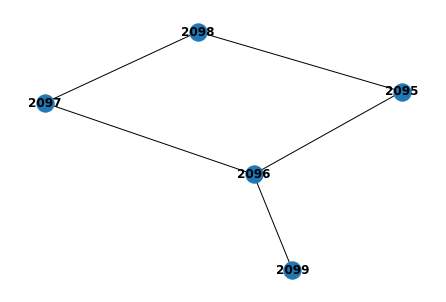

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2085: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 534.25it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.37216064
0.37216064


<Figure size 432x288 with 0 Axes>

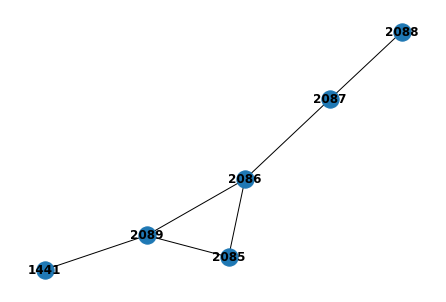

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2765: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 560.85it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.10628514
0.10628514


<Figure size 432x288 with 0 Axes>

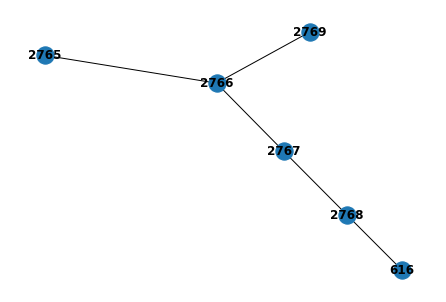

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2260: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 551.89it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.42186627
0.42186627


<Figure size 432x288 with 0 Axes>

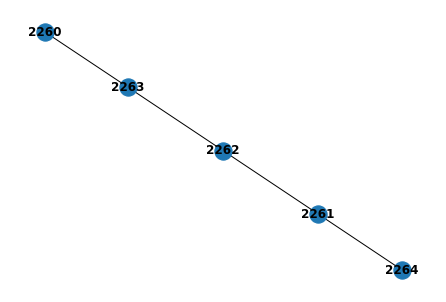

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2445: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 525.13it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.26578853
0.26578853


<Figure size 432x288 with 0 Axes>

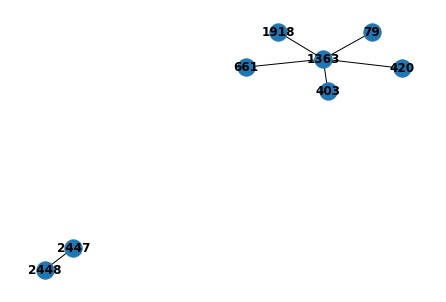

f1_score, ged 0.16666666666666666 9.0
<class 'int'>


Explain node 2565: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 535.54it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.17100593
0.17100593


<Figure size 432x288 with 0 Axes>

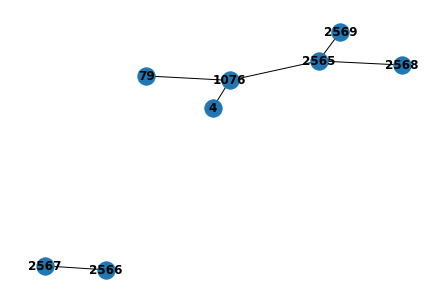

f1_score, ged 0.5 7.0
<class 'int'>


Explain node 2380: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 564.04it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.230116
0.230116


<Figure size 432x288 with 0 Axes>

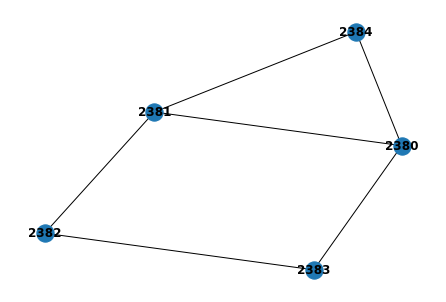

f1_score, ged 1.0 0.0
<class 'int'>


Explain node 2376: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 493.96it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.17590722
0.17590722


<Figure size 432x288 with 0 Axes>

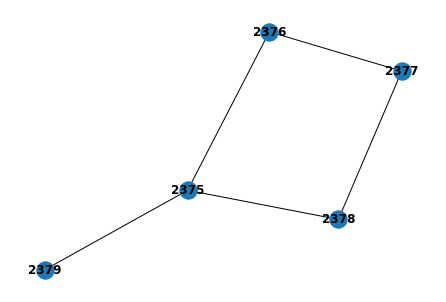

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2505: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 471.20it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.25968146
0.25968146


<Figure size 432x288 with 0 Axes>

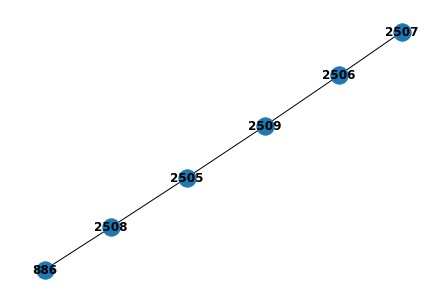

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2290: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 454.88it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3242783
0.3242783


<Figure size 432x288 with 0 Axes>

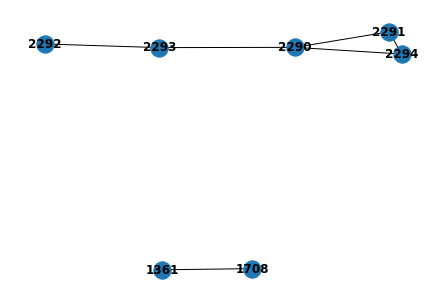

f1_score, ged 0.8333333333333334 4.0
<class 'int'>


Explain node 2361: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 409.19it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.2794758
0.2794758


<Figure size 432x288 with 0 Axes>

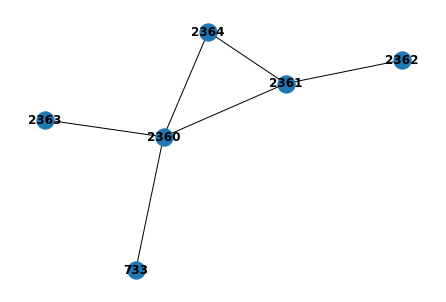

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2031: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 530.24it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3487599
0.3487599


<Figure size 432x288 with 0 Axes>

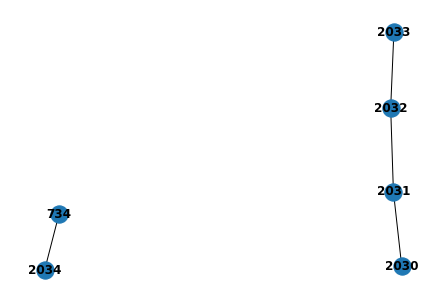

f1_score, ged 0.6 5.0
<class 'int'>


Explain node 2086: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 477.97it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.4257767
0.4257767


<Figure size 432x288 with 0 Axes>

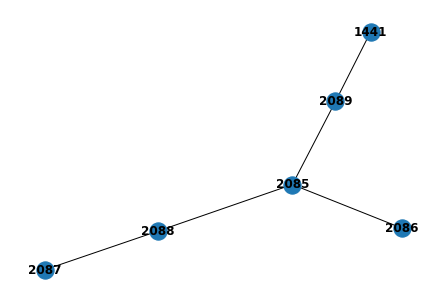

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2941: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 511.50it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.32861966
0.32861966


<Figure size 432x288 with 0 Axes>

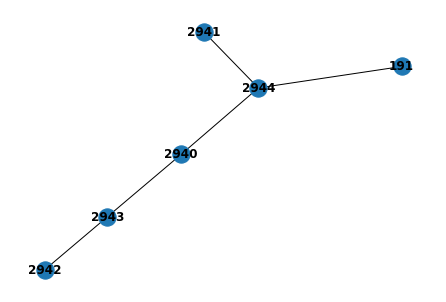

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2731: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 492.06it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.21337181
0.21337181


<Figure size 432x288 with 0 Axes>

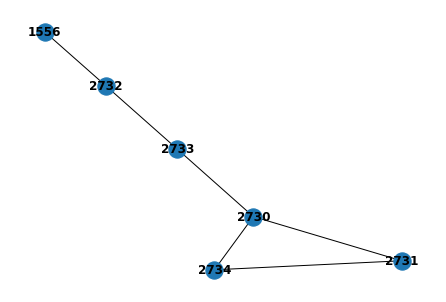

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2281: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 461.38it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.11257389
0.11257389


<Figure size 432x288 with 0 Axes>

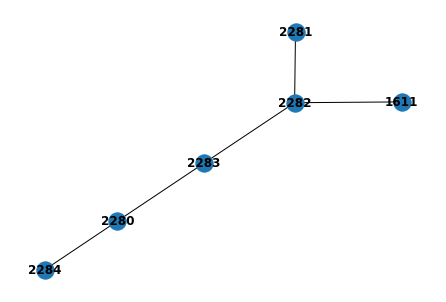

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2571: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 443.97it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36359334
0.36359334


<Figure size 432x288 with 0 Axes>

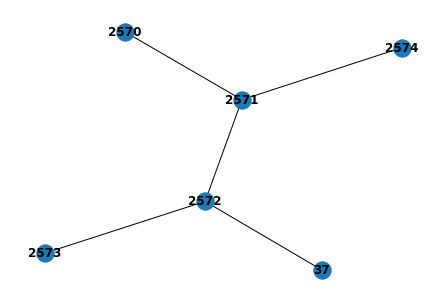

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2611: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 487.69it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.4132749
0.4132749


<Figure size 432x288 with 0 Axes>

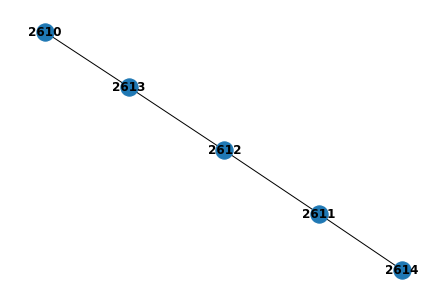

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2715: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 484.76it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.34120926
0.34120926


<Figure size 432x288 with 0 Axes>

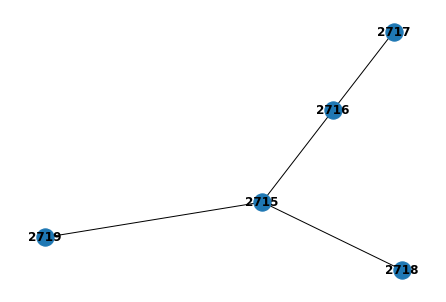

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2456: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 507.99it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.39876252
0.39876252


<Figure size 432x288 with 0 Axes>

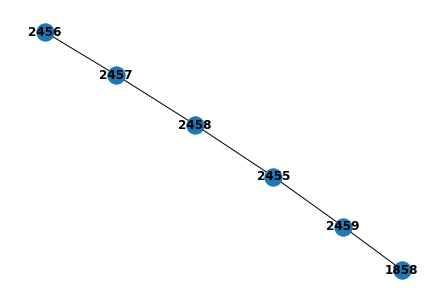

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2495: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 532.60it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.110038295
0.110038295


<Figure size 432x288 with 0 Axes>

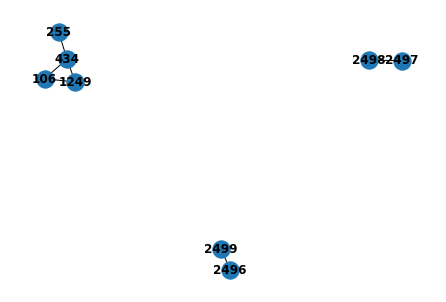

f1_score, ged 0.3333333333333333 7.0
<class 'int'>


Explain node 2540: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 504.57it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.342711
0.342711


<Figure size 432x288 with 0 Axes>

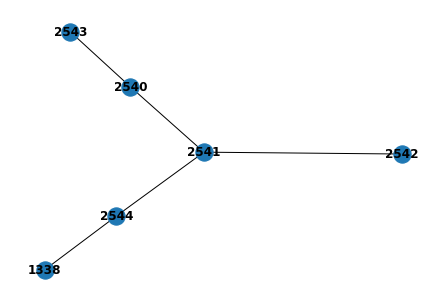

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2580: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 507.48it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.19247983
0.19247983


<Figure size 432x288 with 0 Axes>

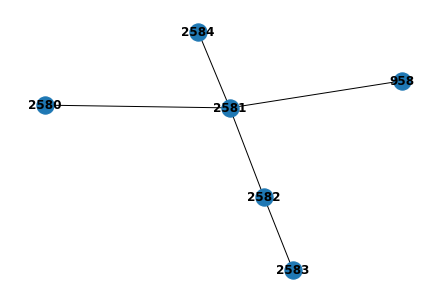

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2585: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 484.15it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.37861022
0.37861022


<Figure size 432x288 with 0 Axes>

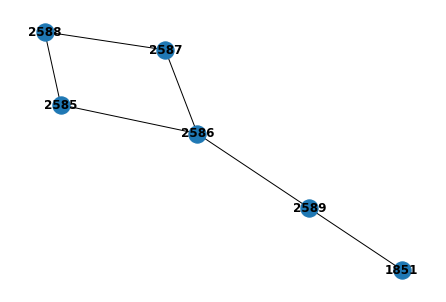

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2251: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 569.66it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3976428
0.3976428


<Figure size 432x288 with 0 Axes>

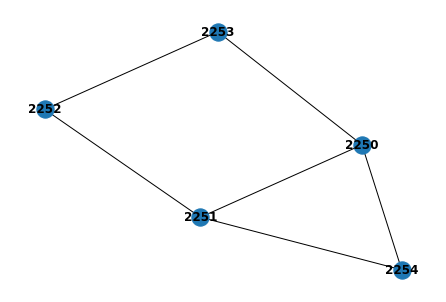

f1_score, ged 1.0 0.0
<class 'int'>


Explain node 2046: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 429.54it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.18224068
0.18224068


<Figure size 432x288 with 0 Axes>

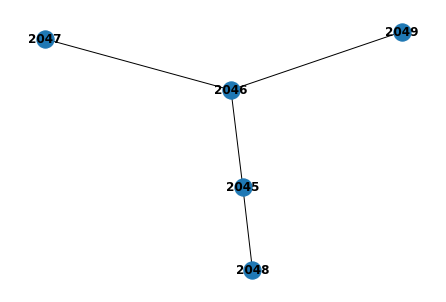

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2190: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 470.80it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.28226662
0.28226662


<Figure size 432x288 with 0 Axes>

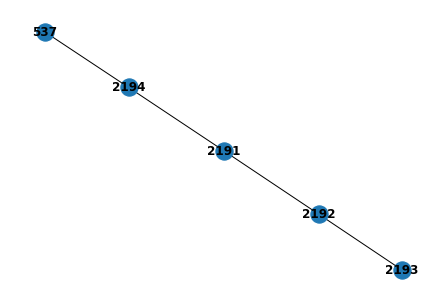

f1_score, ged 0.6 2.0
<class 'int'>


Explain node 2725: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 472.53it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36256576
0.36256576


<Figure size 432x288 with 0 Axes>

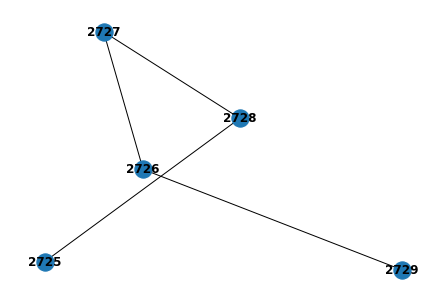

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2231: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 447.26it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.386816
0.386816


<Figure size 432x288 with 0 Axes>

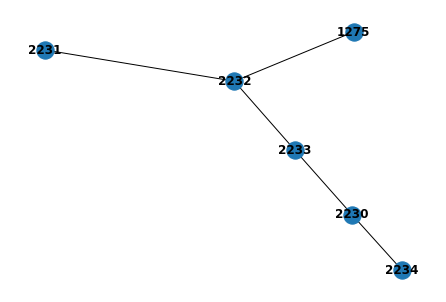

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2870: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 583.73it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3861019
0.3861019


<Figure size 432x288 with 0 Axes>

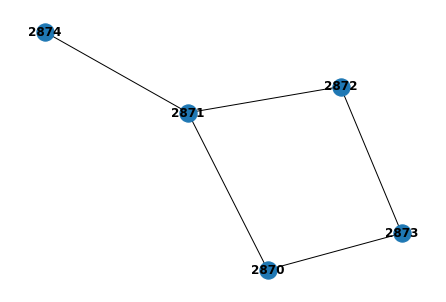

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2460: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 529.61it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.43824106
0.43824106


<Figure size 432x288 with 0 Axes>

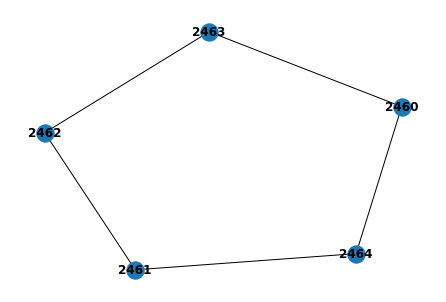

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2131: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 558.26it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.41119194
0.41119194


<Figure size 432x288 with 0 Axes>

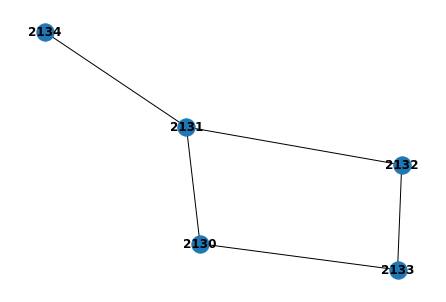

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2956: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 548.21it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.20405872
0.20405872


<Figure size 432x288 with 0 Axes>

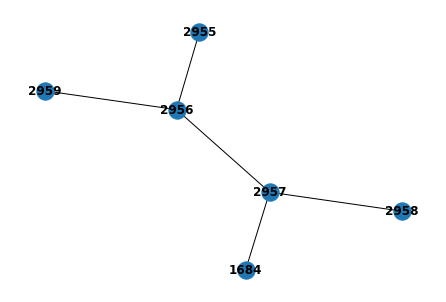

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2020: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 563.82it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.28112888
0.28112888


<Figure size 432x288 with 0 Axes>

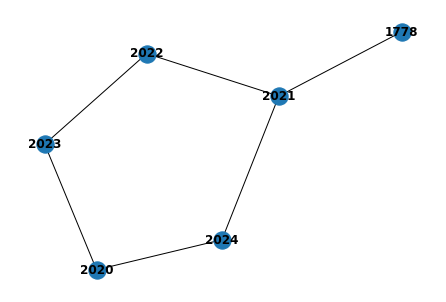

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2796: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 542.83it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.38476798
0.38476798


<Figure size 432x288 with 0 Axes>

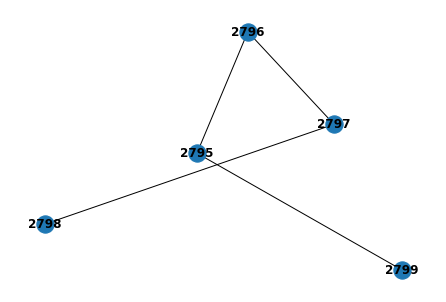

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2681: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 535.18it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.35542688
0.35542688


<Figure size 432x288 with 0 Axes>

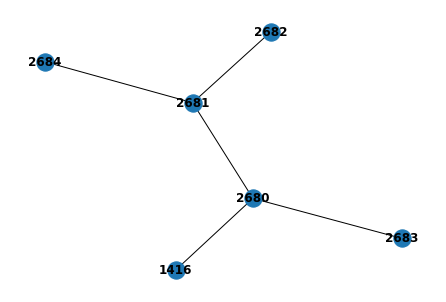

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2035: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 573.44it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3291123
0.3291123


<Figure size 432x288 with 0 Axes>

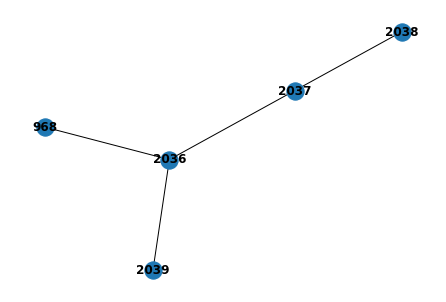

f1_score, ged 0.6 2.0
<class 'int'>


Explain node 2145: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 538.35it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.40053692
0.40053692


<Figure size 432x288 with 0 Axes>

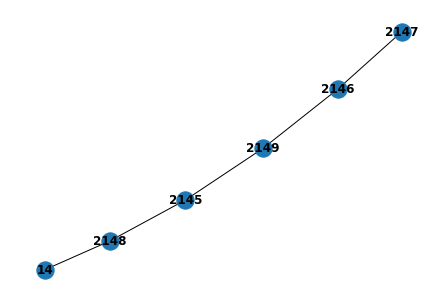

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2935: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 572.76it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3939546
0.3939546


<Figure size 432x288 with 0 Axes>

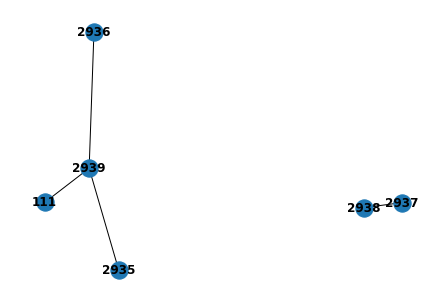

f1_score, ged 0.6 5.0
<class 'int'>


Explain node 2450: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 534.62it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.40774465
0.40774465


<Figure size 432x288 with 0 Axes>

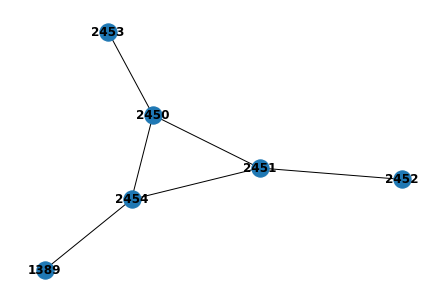

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2366: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 553.75it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.34390432
0.34390432


<Figure size 432x288 with 0 Axes>

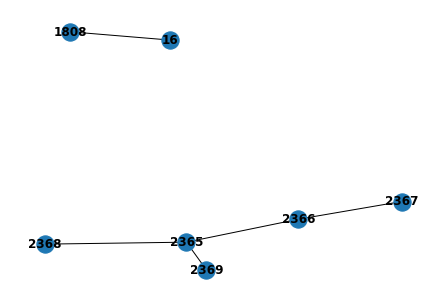

f1_score, ged 0.7272727272727272 5.0
<class 'int'>


Explain node 2631: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 543.35it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.39045563
0.39045563


<Figure size 432x288 with 0 Axes>

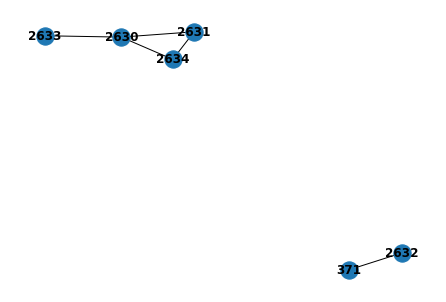

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2485: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 571.07it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.37790236
0.37790236


<Figure size 432x288 with 0 Axes>

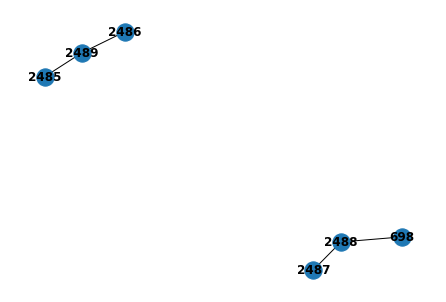

f1_score, ged 0.6 5.0
<class 'int'>


Explain node 2340: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 557.86it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.26899892
0.26899892


<Figure size 432x288 with 0 Axes>

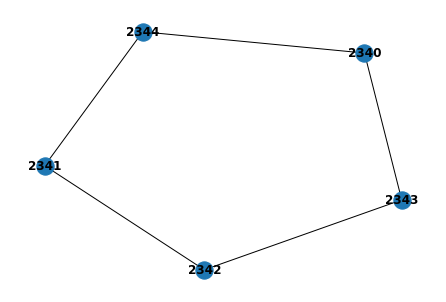

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2371: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 546.61it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.38397136
0.38397136


<Figure size 432x288 with 0 Axes>

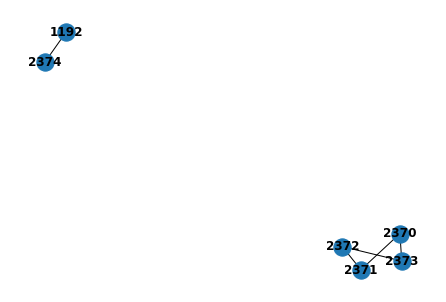

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2726: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 558.05it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.2166423
0.2166423


<Figure size 432x288 with 0 Axes>

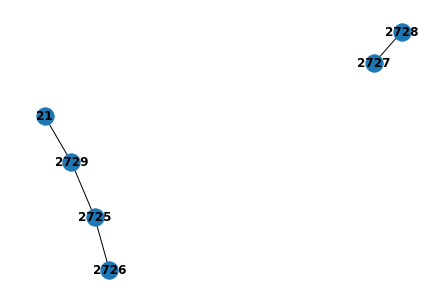

f1_score, ged 0.6 5.0
<class 'int'>


Explain node 2166: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 560.55it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.22237332
0.22237332


<Figure size 432x288 with 0 Axes>

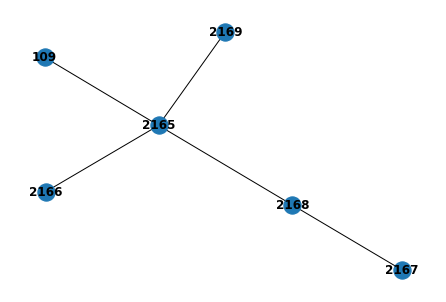

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2885: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 547.61it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.27271563
0.27271563


<Figure size 432x288 with 0 Axes>

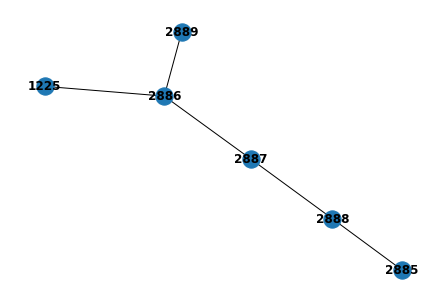

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2896: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 538.37it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3489704
0.3489704


<Figure size 432x288 with 0 Axes>

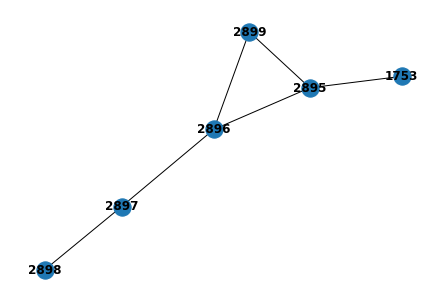

f1_score, ged 0.8333333333333334 3.0
<class 'int'>


Explain node 2115: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 538.04it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.31691915
0.31691915


<Figure size 432x288 with 0 Axes>

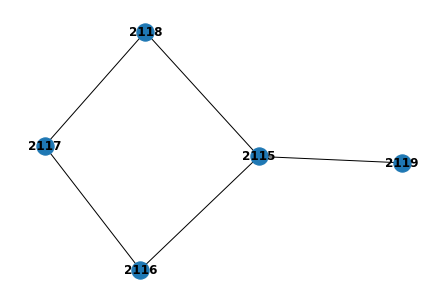

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2150: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 548.56it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.294366
0.294366


<Figure size 432x288 with 0 Axes>

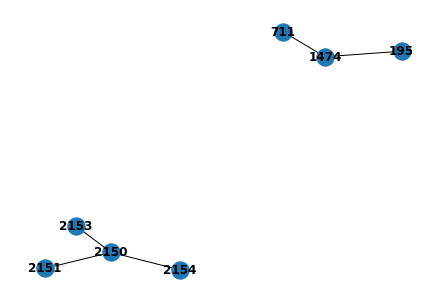

f1_score, ged 0.5454545454545454 7.0
<class 'int'>


Explain node 2925: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 574.69it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3462337
0.3462337


<Figure size 432x288 with 0 Axes>

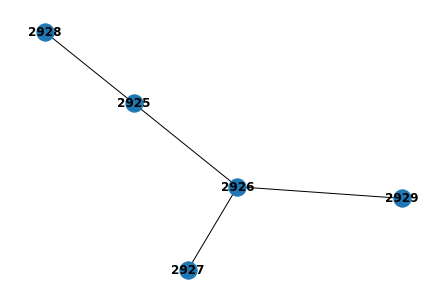

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2151: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 543.67it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.40246162
0.40246162


<Figure size 432x288 with 0 Axes>

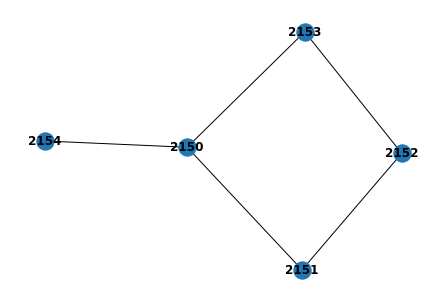

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2516: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 540.33it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.31454417
0.31454417


<Figure size 432x288 with 0 Axes>

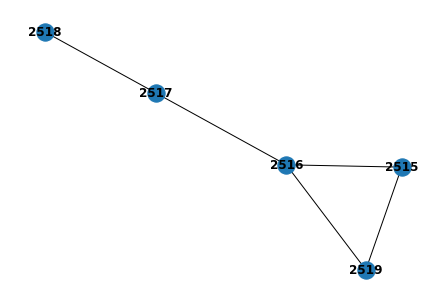

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2495: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 536.35it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.14862257
0.14862257


<Figure size 432x288 with 0 Axes>

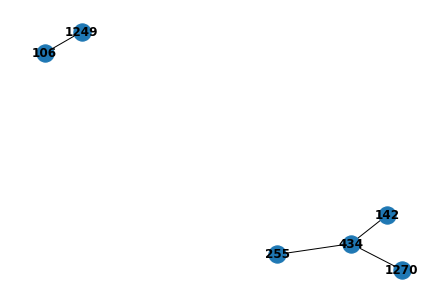

f1_score, ged 0 5.0
<class 'int'>


Explain node 2700: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 553.65it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.4159334
0.4159334


<Figure size 432x288 with 0 Axes>

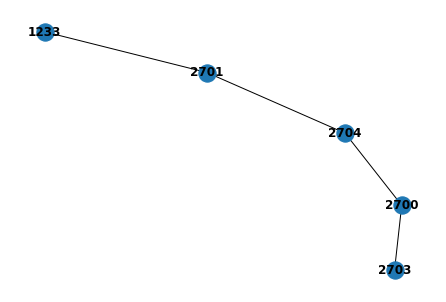

f1_score, ged 0.6 2.0
<class 'int'>


Explain node 2921: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 538.05it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.24782348
0.24782348


<Figure size 432x288 with 0 Axes>

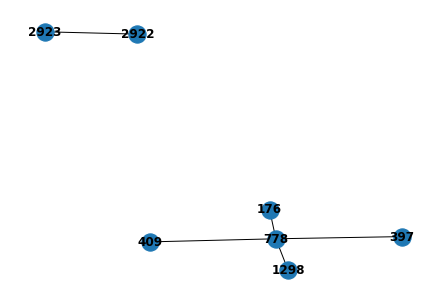

f1_score, ged 0.1818181818181818 7.0
<class 'int'>


Explain node 2491: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 558.57it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.2261223
0.2261223


<Figure size 432x288 with 0 Axes>

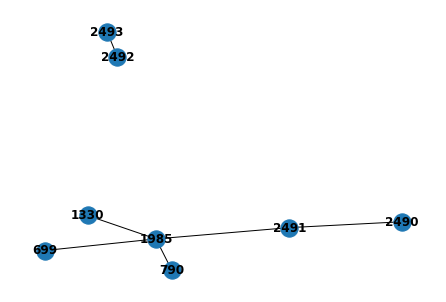

f1_score, ged 0.3333333333333333 7.0
<class 'int'>


Explain node 2431: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 544.50it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.39713916
0.39713916


<Figure size 432x288 with 0 Axes>

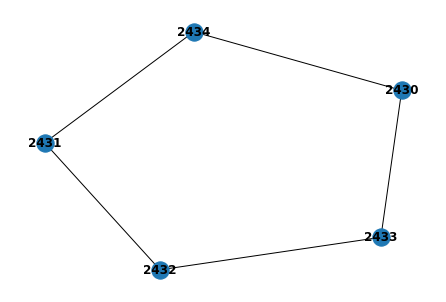

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2775: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 539.70it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.37153566
0.37153566


<Figure size 432x288 with 0 Axes>

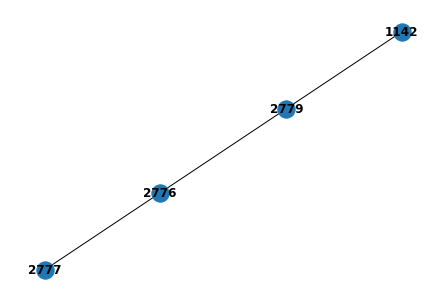

f1_score, ged 0.4444444444444444 4.0
<class 'int'>


Explain node 2626: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 540.61it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3794478
0.3794478


<Figure size 432x288 with 0 Axes>

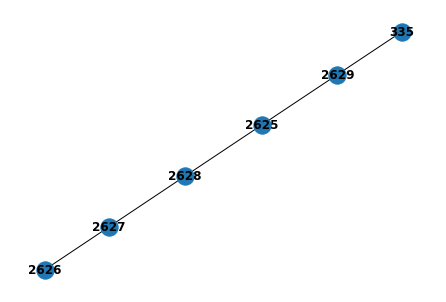

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2746: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 547.36it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3582892
0.3582892


<Figure size 432x288 with 0 Axes>

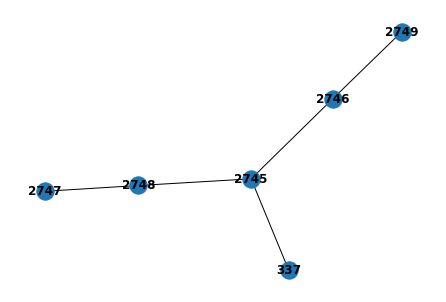

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2911: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 568.85it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.309679
0.309679


<Figure size 432x288 with 0 Axes>

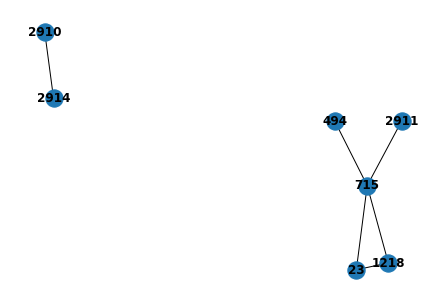

f1_score, ged 0.16666666666666666 6.0
<class 'int'>


Explain node 2451: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 539.39it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.27752116
0.27752116


<Figure size 432x288 with 0 Axes>

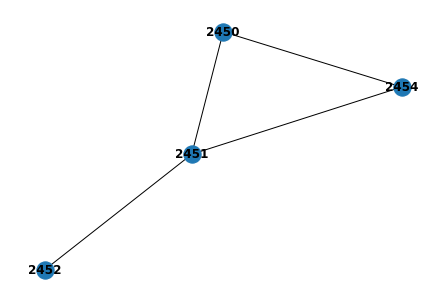

f1_score, ged 0.8 3.0
<class 'int'>


Explain node 2206: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 539.37it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.35655344
0.35655344


<Figure size 432x288 with 0 Axes>

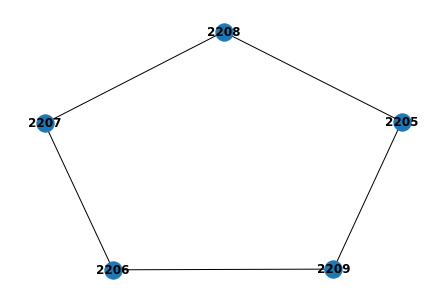

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2041: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 547.64it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.32740656
0.32740656


<Figure size 432x288 with 0 Axes>

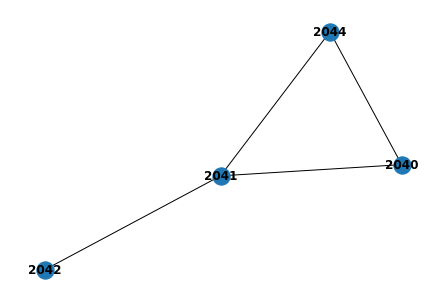

f1_score, ged 0.8 3.0
<class 'int'>


Explain node 2190: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 545.35it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.35130465
0.35130465


<Figure size 432x288 with 0 Axes>

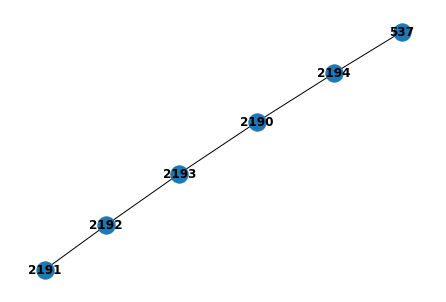

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2571: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 547.54it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.30197662
0.30197662


<Figure size 432x288 with 0 Axes>

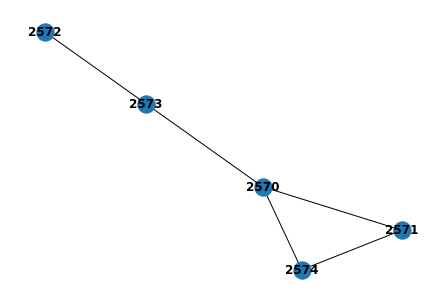

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2526: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 526.13it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.032631967
0.032631967


<Figure size 432x288 with 0 Axes>

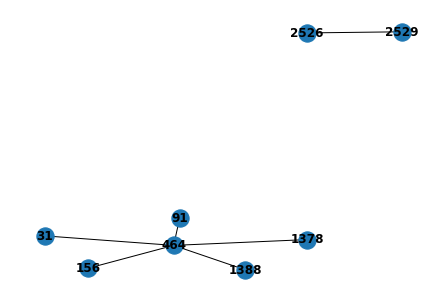

f1_score, ged 0.16666666666666666 9.0
<class 'int'>


Explain node 2431: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 581.03it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.29486498
0.29486498


<Figure size 432x288 with 0 Axes>

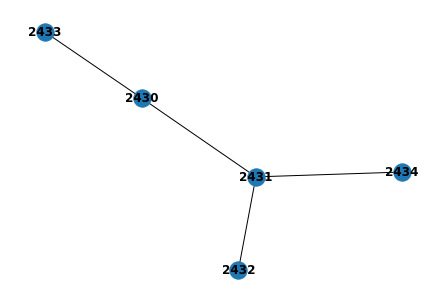

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2065: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 545.44it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.37667546
0.37667546


<Figure size 432x288 with 0 Axes>

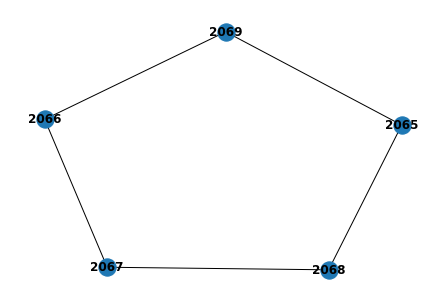

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2690: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 500.16it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3677316
0.3677316


<Figure size 432x288 with 0 Axes>

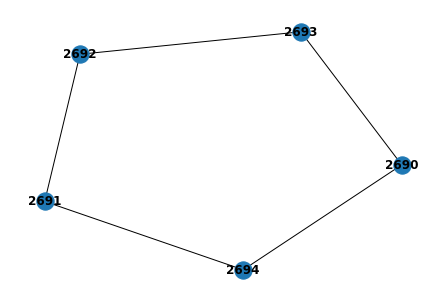

f1_score, ged 0.9090909090909091 1.0
<class 'int'>


Explain node 2786: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 523.47it/s]


zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3964004
0.3964004


<Figure size 432x288 with 0 Axes>

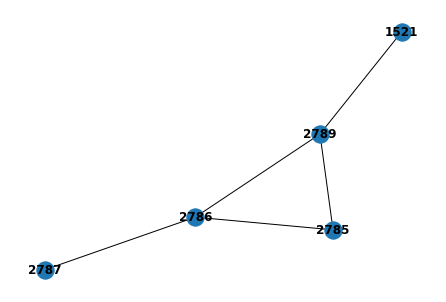

f1_score, ged 0.7272727272727272 1.0
<class 'int'>


Explain node 2371: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 479.18it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.27368182
0.27368182


<Figure size 432x288 with 0 Axes>

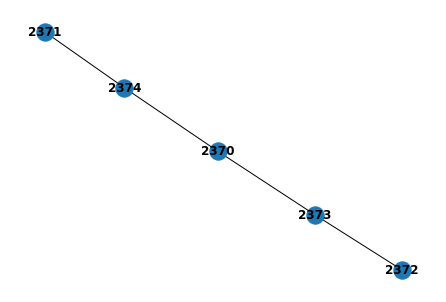

f1_score, ged 0.8 2.0
<class 'int'>


Explain node 2596: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 475.15it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.248251
0.248251


<Figure size 432x288 with 0 Axes>

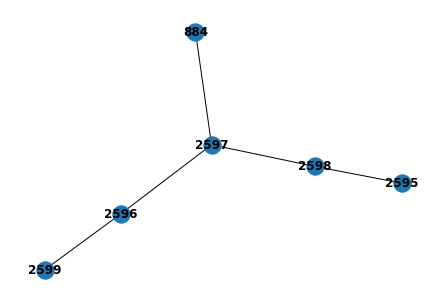

f1_score, ged 0.7272727272727272 4.0
<class 'int'>


Explain node 2761: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 459.85it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.08239322
0.08239322


<Figure size 432x288 with 0 Axes>

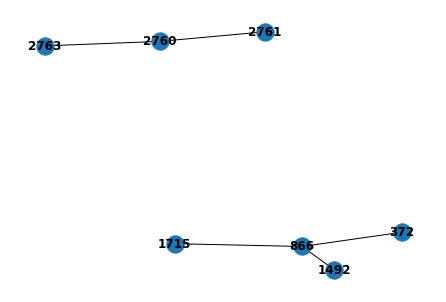

f1_score, ged 0.3636363636363636 7.0
<class 'int'>


Explain node 2055: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 440.12it/s]

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.1781055
0.1781055


<Figure size 432x288 with 0 Axes>

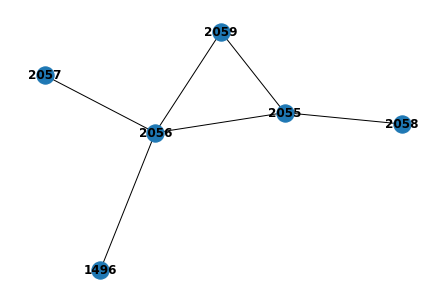

f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

In [255]:
from torch_geometric.nn import GNNExplainer
import random

print(test_nodes)
F1_scores = []
GED = []
Recall = []
Precision = []
related_preds = []
AUC = []

explainer = GNNExplainer(model)
for node_idx in test_nodes:
    print(type(node_idx))
    node_feat_mask, edge_mask = explainer.explain_node(node_idx, x = data.x, edge_index = data.edge_index)
    node_feat_mask, edge_mask = node_feat_mask.detach().numpy(), edge_mask.detach().numpy()
    
    related_preds = add_related_pred(model, data, related_preds, edge_mask, node_idx)
    recall, precision, f1_score, ged, auc = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    AUC.append(auc)
    print("f1_score, ged", f1_score, ged)

In [256]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision), np.mean(AUC))


new_related_preds={}
for k,v in [(key,d[key]) for d in related_preds for key in d]:
  if k not in new_related_preds: new_related_preds[k]=np.array([v])
  else: np.append(new_related_preds[k], v)
    
print("fidelity+ (-->1): ", fidelity(new_related_preds))
print("fidelity- (-->0): ", fidelity_inv(new_related_preds))

0.7350252525252524 3.155 0.6691666666666667 0.8248333333333335 0.9999215703521271
fidelity+ (-->1):  0.02039259672164917
fidelity- (-->0):  0.008747190237045288


In [346]:
from scipy.special import softmax

def eval_related_pred(model, data, edge_masks, list_node_idx, hard_mask=False, **kwargs):

    zero_mask = torch.zeros(data.edge_index.shape[1])

    ori_preds = model(data.x, data.edge_index)
    zero_mask_preds = model(x=data.x, edge_index=data.edge_index, edge_weight=zero_mask)
    
    
    n_test = len(list_node_idx)
    related_preds = []
    
    for i in range(n_test):
    
        edge_mask = torch.Tensor(edge_masks[i])
        node_idx = list_node_idx[i]

        if hard_mask:
            #masked_edge_index = data.edge_index[:,edge_mask>kwargs['threshold']]
            #maskout_edge_index = data.edge_index[:,1-edge_mask>kwargs['threshold']]

            indices = (-edge_mask).argsort()[:kwargs['num_top_edges']]
            indices_inv = [i for i in range(len(edge_mask)) if i not in indices]
            masked_edge_index = data.edge_index[:, indices]
            maskout_edge_index = data.edge_index[:, indices_inv]

            masked_preds = model(data.x, masked_edge_index)
            maskout_preds = model(data.x, maskout_edge_index)
        else:
            masked_preds = model(x=data.x, edge_index=data.edge_index, edge_weight=edge_mask)
            maskout_preds = model(x=data.x, edge_index=data.edge_index, edge_weight=1-edge_mask)


        ori_probs = softmax(ori_preds[node_idx].detach().numpy())
        masked_probs = softmax(masked_preds[node_idx].detach().numpy())
        maskout_probs = softmax(maskout_preds[node_idx].detach().numpy())
        zero_mask_probs = softmax(zero_mask_preds[node_idx].detach().numpy())

        true_label = data.y[node_idx].detach().numpy()
        pred_label = np.argmax(ori_probs)
        assert true_label==pred_label, "The label predicted by the GCN does not match the true label."

        related_preds.append({'zero': zero_mask_probs,
                                      'masked': masked_probs,
                                      'maskout': maskout_probs,
                                      'origin': ori_probs,
                                        'true_label': true_label})
        
    related_preds = list_to_dict(related_preds)
    return related_preds




def fidelity_acc(related_preds):
    labels = related_preds['true_label']
    ori_labels = np.argmax(related_preds['origin'], axis=1)
    unimportant_labels = np.argmax(related_preds['maskout'], axis=1)
    p_1 = np.array(ori_labels==labels).astype(int)
    p_2 = np.array(unimportant_labels==labels).astype(int)
    drop_probability = p_1 - p_2
    return drop_probability.mean().item()

def fidelity_acc_inv(related_preds):
    labels = related_preds['true_label']
    ori_labels = np.argmax(related_preds['origin'], axis=1)
    important_labels = np.argmax(related_preds['masked'], axis=1)
    p_1 = np.array([ori_labels==labels]).astype(int)
    p_2 = np.array([important_labels==labels]).astype(int)
    drop_probability = p_1 - p_2
    return drop_probability.mean().item()

# Fidelity+  metric  studies  the  prediction  change  by
# removing  important  nodes/edges/node  features. 
# Higher fidelity+ value indicates good explanations -->1
def fidelity_prob(related_preds):
    ori_probs = np.max(related_preds['origin'], axis=1)
    unimportant_probs = np.max(related_preds['maskout'], axis=1)
    drop_probability = np.abs(ori_probs - unimportant_probs)
    return drop_probability.mean().item()

# Fidelity-  metric  studies  the  prediction  change  by
# removing  unimportant  nodes/edges/node  features. 
# Lower fidelity- value indicates good explanations -->0
def fidelity_prob_inv(related_preds):
    ori_probs = np.max(related_preds['origin'], axis=1)
    important_probs = np.max(related_preds['masked'], axis=1)
    drop_probability = ori_probs - important_probs
    return drop_probability.mean().item()
    
    

In [347]:
def eval_fidelity(related_preds):
    fidelity_scores = {
        "fidelity_acc+": fidelity_acc(related_preds),
        "fidelity_acc-": fidelity_acc_inv(related_preds),
        "fidelity_prob+": fidelity_prob(related_preds),
        "fidelity_prob-": fidelity_prob_inv(related_preds),
    }
    return fidelity_scores
    
    


In [304]:
threshold = 0.5
num_top_edges = 6

indices = (-edge_mask).argsort()[:num_top_edges]
indices_inv = [i for i in range(len(edge_mask)) if i not in indices]
print(indices)
masked_edge_index = data.edge_index[:, indices]
maskout_edge_index = data.edge_index[:, indices_inv]
#masked_edge_index = data.edge_index[:,edge_mask>threshold]
#maskout_edge_index = data.edge_index[:,1-edge_mask>threshold]
print(masked_edge_index.shape)
print(maskout_edge_index.shape)

pred = model(data.x, data.edge_index)
masked_pred = model(data.x, masked_edge_index)
maskout_pred = model(data.x, maskout_edge_index)

label = data.y[node_idx].detach().numpy()

masked_prob = softmax(masked_pred[node_idx].detach().numpy())
maskout_prob = softmax(maskout_pred[node_idx].detach().numpy())
prob = softmax(pred[node_idx].detach().numpy())
print(prob)
print(masked_prob)
print(maskout_prob)

[20828 20826 20827 20831 20830 20834]
torch.Size([2, 6])
torch.Size([2, 22744])
[0.21939145 0.40940237 0.2627852  0.10842102]
[0.24865082 0.36441252 0.27041614 0.11652058]
[0.98512477 0.01090296 0.00206332 0.0019089 ]


In [148]:
from captum._utils.common import (
    _format_additional_forward_args,
    _format_input,
    _format_output,
)
from captum._utils.gradient import (
    apply_gradient_requirements,
    compute_layer_gradients_and_eval,
    undo_gradient_requirements,
)
from captum._utils.typing import TargetType
from captum.attr import Saliency, IntegratedGradients, LayerGradCam

In [149]:
def mask_to_directed(edge_mask, edge_index):
    directed_edge_mask = edge_mask.copy()
    for i, (u, v) in enumerate(edge_index.t().tolist()):
        if u > v:
            directed_edge_mask[i]=0
    return directed_edge_mask

In [150]:
def model_forward(edge_mask, model, node_idx, x, edge_index):
    out = model(x, edge_index, edge_mask)
    return out[[node_idx]]

def model_forward_node(x, model, edge_index, node_idx):
    out = model(x, edge_index)
    return out[[node_idx]]

def node_attr_to_edge(edge_index, node_mask):
    edge_mask = np.zeros(edge_index.shape[1])
    edge_mask += node_mask[edge_index[0].cpu().numpy()]
    edge_mask += node_mask[edge_index[1].cpu().numpy()]
    return edge_mask

In [151]:
def explain_sa(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward)
    input_mask = torch.ones(edge_index.shape[1]).requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target,
                                       additional_forward_args=(model, node_idx, x, edge_index), abs=False)

    edge_mask = saliency_mask.cpu().numpy()
    return edge_mask

def explain_sa_node(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                                       abs=False)

    node_attr = saliency_mask.cpu().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

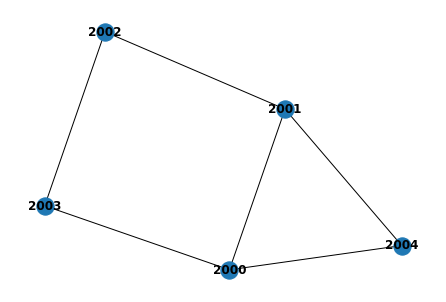

ValueError: too many values to unpack (expected 4)

<Figure size 432x288 with 0 Axes>

In [326]:
list_node_idx = range(n_basis,n_basis+500)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_sa_node(model, node_idx, data.x, data.edge_index, target = labels[node_idx])
    #print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    #print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [29]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.22946859903381642 7.521739130434782 0.22946859903381642 0.22946859903381642


In [185]:
def explain_ig_node(model, node_idx, x, edge_index, target, include_edges=None):
    ig = IntegratedGradients(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    ig_mask = ig.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                           internal_batch_size=input_mask.shape[0])

    node_attr = ig_mask.cpu().detach().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [333]:
list_node_idx = range(n_basis,n_basis+50)#*n_shapes)

edge_masks = []

for node_idx in test_nodes:
    edge_mask = explain_ig_node(model, node_idx, data.x, data.edge_index, labels[node_idx])
    #print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    edge_masks.append(edge_mask)    

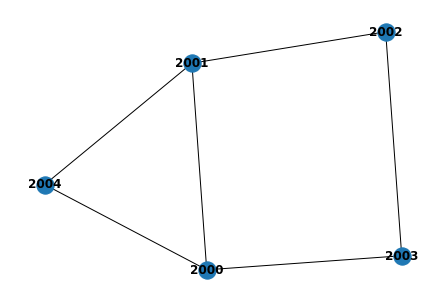

<Figure size 432x288 with 0 Axes>

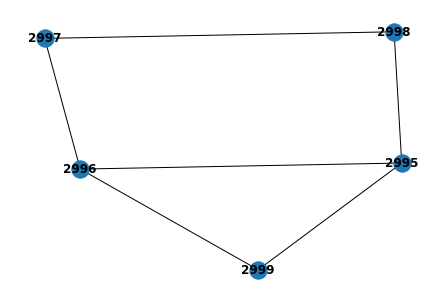

<Figure size 432x288 with 0 Axes>

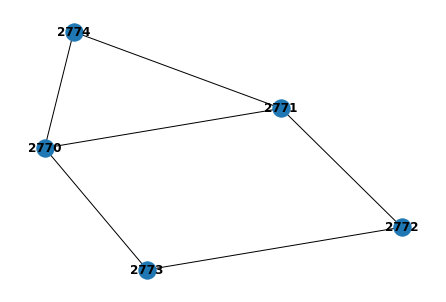

<Figure size 432x288 with 0 Axes>

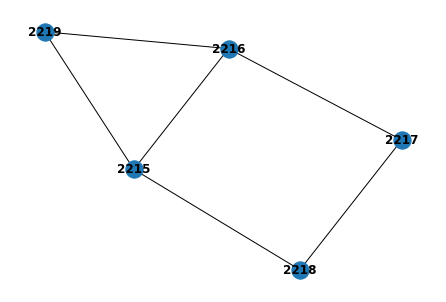

<Figure size 432x288 with 0 Axes>

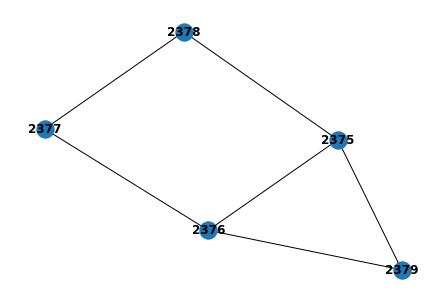

<Figure size 432x288 with 0 Axes>

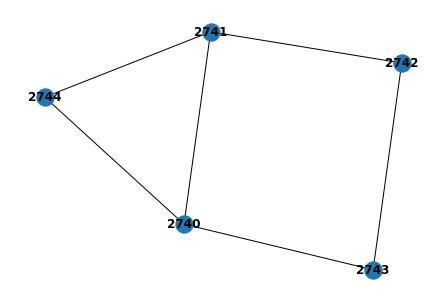

<Figure size 432x288 with 0 Axes>

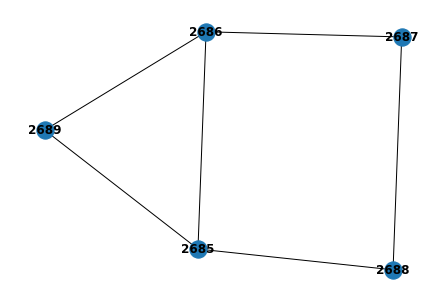

<Figure size 432x288 with 0 Axes>

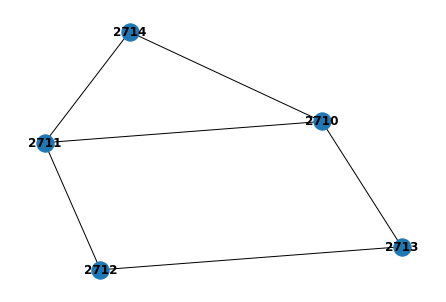

<Figure size 432x288 with 0 Axes>

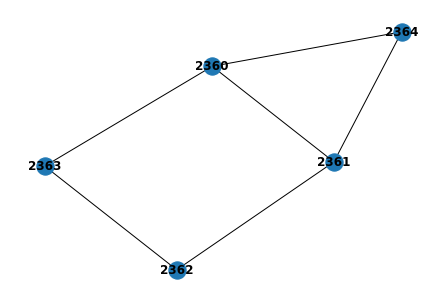

<Figure size 432x288 with 0 Axes>

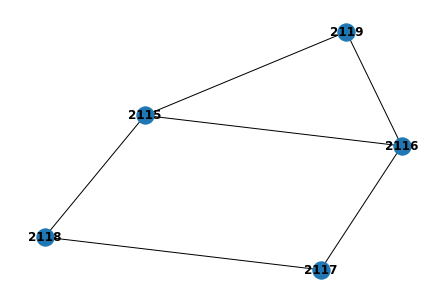

<Figure size 432x288 with 0 Axes>

In [338]:
soft_related_preds = eval_related_pred(model, data, edge_masks, test_nodes, hard_mask=False)
hard_related_preds = eval_related_pred(model, data, edge_masks, test_nodes, hard_mask=True, num_top_edges=6)


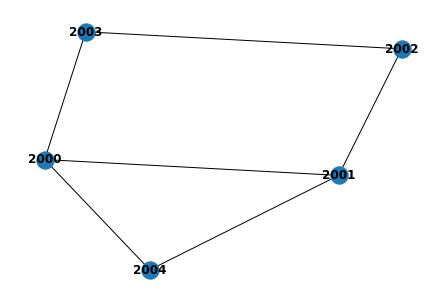

<Figure size 432x288 with 0 Axes>

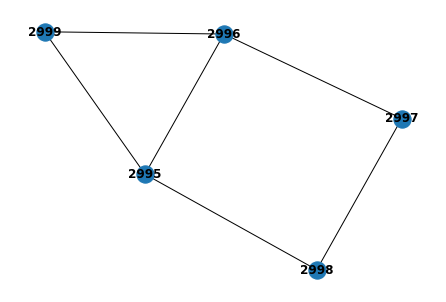

<Figure size 432x288 with 0 Axes>

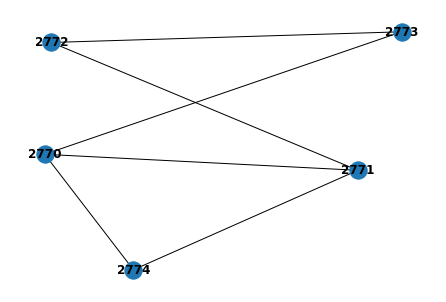

<Figure size 432x288 with 0 Axes>

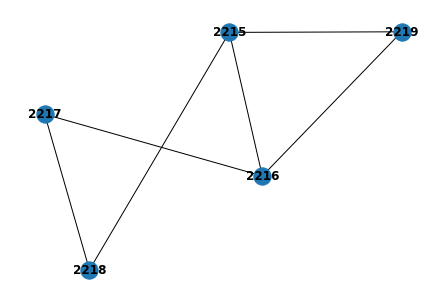

<Figure size 432x288 with 0 Axes>

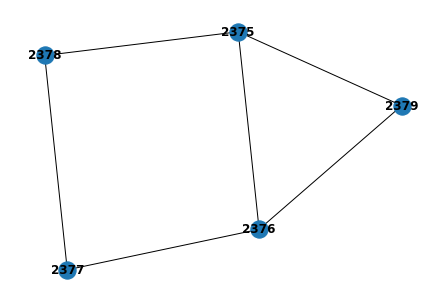

<Figure size 432x288 with 0 Axes>

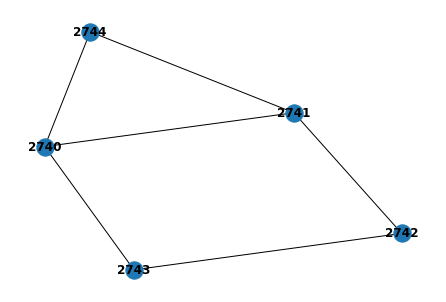

<Figure size 432x288 with 0 Axes>

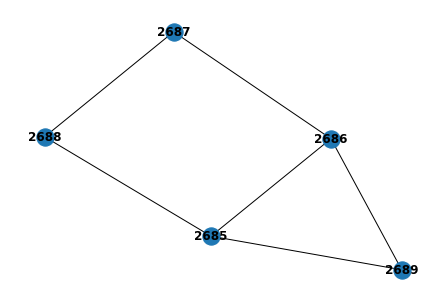

<Figure size 432x288 with 0 Axes>

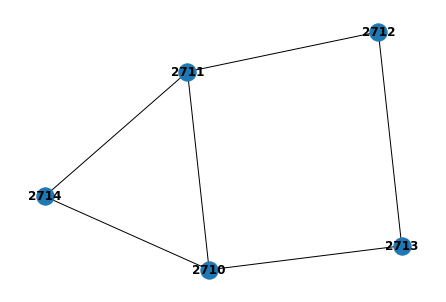

<Figure size 432x288 with 0 Axes>

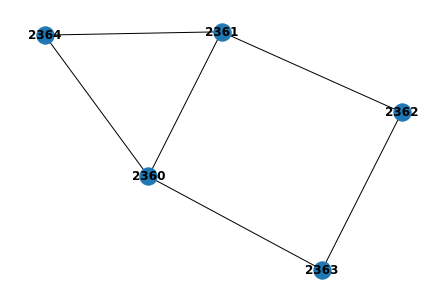

<Figure size 432x288 with 0 Axes>

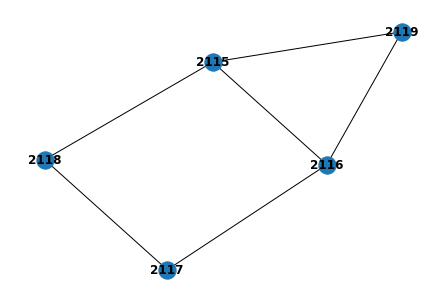

{'recall': 1.0,
 'precision': 1.0,
 'f1_score': 1.0,
 'ged': 0.0,
 'auc': 0.749916439440584}

<Figure size 432x288 with 0 Axes>

In [364]:
acc = eval_accuracy(data, edge_masks, test_nodes, num_top_edges=6, is_hard_mask=False)
acc

In [369]:
f1 = eval_fidelity(soft_related_preds)
f1 = {k+'_soft':v for k,v in f1.items()}
f1

{'fidelity_acc+_soft': 0.9,
 'fidelity_acc-_soft': 0.0,
 'fidelity_prob+_soft': 0.06673536449670792,
 'fidelity_prob-_soft': -0.00027086734189651906}

In [367]:
f2 = eval_fidelity(hard_related_preds)
f2

{'fidelity_acc+': 1.0,
 'fidelity_acc-': 0.6,
 'fidelity_prob+': 0.5075659155845642,
 'fidelity_prob-': -0.1716432124376297}

In [362]:
f1.update(f2)

In [368]:
f1.update(f2)
f1

{'fidelity_acc+': 1.0,
 'fidelity_acc-': 0.6,
 'fidelity_prob+': 0.5075659155845642,
 'fidelity_prob-': -0.1716432124376297}

In [328]:
def list_to_dict(preds):
    preds_dict=pd.DataFrame(preds).to_dict('list')
    for key in preds_dict.keys():
        preds_dict[key] = np.array(preds_dict[key])
    return(preds_dict)


In [322]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision), np.mean(AUC))


print("fidelity+ (-->1) with soft mask: ", fidelity_prob(soft_dict))
print("fidelity- (-->0) with soft mask: ", fidelity_prob_inv(soft_dict))


print("fidelity+ prob (-->1) with hard mask: ", fidelity_prob(hard_dict))
print("fidelity- prob (-->0) with hard mask: ", fidelity_prob_inv(hard_dict))



0.9868913857677903 0.23595505617977527 0.9868913857677903 0.9868913857677903 0.7496330533486322
fidelity+ (-->1) with soft mask:  0.10329630225896835
fidelity- (-->0) with soft mask:  -7.450580596923828e-09
fidelity+ prob (-->1) with hard mask:  0.3076222836971283
fidelity- prob (-->0) with hard mask:  -7.952866698524019e-10


In [323]:
print("fidelity+ acc (-->1) with soft mask: ", fidelity_acc(soft_dict))
print("fidelity- acc (-->0) with soft mask: ", fidelity_acc_inv(soft_dict))


print("fidelity+ acc (-->1) with hard mask: ", fidelity_acc(hard_dict))
print("fidelity- acc (-->0) with hard mask: ", fidelity_acc_inv(hard_dict))

fidelity+ acc (-->1) with soft mask:  0.7777777777777778
fidelity- acc (-->0) with soft mask:  0.07777777777777778
fidelity+ acc (-->1) with hard mask:  1.0
fidelity- acc (-->0) with hard mask:  0.6629213483146067


In [32]:
def explain_occlusion(model, node_idx, x, edge_index, target, include_edges=None):
    depth_limit = model.num_layers + 1
    data = Data(x=x, edge_index=edge_index)
    pred_prob = model(data.x, data.edge_index)[node_idx][target].item()
    g = to_networkx(data)
    subgraph_nodes = []
    for k, v in nx.shortest_path_length(g, target=node_idx).items():
        if v < depth_limit:
            subgraph_nodes.append(k)
    subgraph = g.subgraph(subgraph_nodes)
    edge_occlusion_mask = np.ones(data.num_edges, dtype=bool)
    edge_mask = np.zeros(data.num_edges)
    edge_index_numpy = data.edge_index.cpu().numpy()
    for i in range(data.num_edges):
        if include_edges is not None and not include_edges[i].item():
            continue
        u, v = list(edge_index_numpy[:, i])
        if (u, v) in subgraph.edges():
            edge_occlusion_mask[i] = False
            prob = model(data.x, data.edge_index[:, edge_occlusion_mask])[node_idx][target].item()
            edge_mask[i] = pred_prob - prob
            edge_occlusion_mask[i] = True
    return edge_mask


[0.01549125 0.4204604  0.17534226 0.18984991 0.4204604  0.05009085
 0.34293252 0.18984991 0.4264254 ]


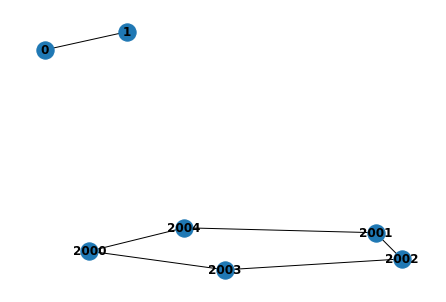

tensor([[2000, 2001, 2001, 2002, 2000,    0],
        [2004, 2004, 2002, 2003, 2003,    1]])
f1_score, ged 0.8333333333333334 4.0
[0.12051469 0.41694516 0.07163423 0.1895954  0.41694516 0.18146259
 0.07163423 0.1895954  0.10912126 0.18146259]


<Figure size 432x288 with 0 Axes>

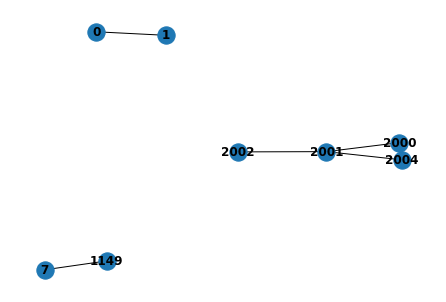

tensor([[2000, 2001, 2001, 2000,    0, 1149],
        [2004, 2004, 2002, 2001,    1,    7]])
f1_score, ged 0.6666666666666666 7.0
[0.02603137 0.00718439 0.46472955 0.23338819 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

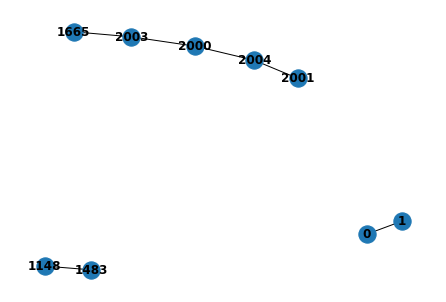

tensor([[2000, 2001, 1665, 2000,    0, 1148],
        [2004, 2004, 2003, 2003,    1, 1483]])
f1_score, ged 0.5 8.0
[1.67100430e-02 9.87148285e-03 2.71797180e-05 1.99079514e-04
 1.48463249e-03 1.48463249e-03 1.48463249e-03 6.90361261e-02
 5.58915138e-02 1.61062956e-01 9.20534134e-03 2.72258520e-02
 1.61062956e-01 5.58915138e-02 2.18153000e-04 9.20534134e-03
 2.72258520e-02 5.58915138e-02]


<Figure size 432x288 with 0 Axes>

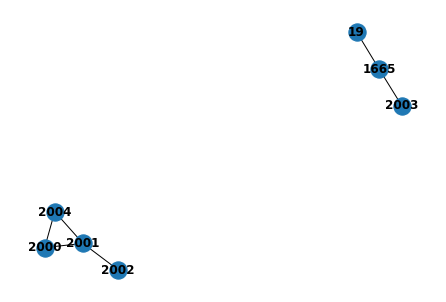

tensor([[2000, 2001, 1665, 2000, 2001,   19],
        [2004, 2004, 2003, 2001, 2002, 1665]])
f1_score, ged 0.6666666666666666 6.0
[0.03252065 0.02846277 0.49933362 0.14103723 0.2866776  0.103526
 0.02269602 0.02846277 0.14103723 0.2866776  0.14032996 0.02269602]


<Figure size 432x288 with 0 Axes>

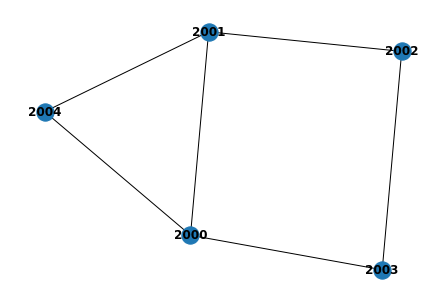

tensor([[2000, 2001, 2001, 2000, 2000, 2002],
        [2004, 2002, 2004, 2001, 2003, 2003]])
f1_score, ged 1.0 0.0
[0.01549125 0.4204604  0.17534226 0.18984991 0.4204604  0.05009085
 0.34293252 0.18984991 0.4264254 ]


<Figure size 432x288 with 0 Axes>

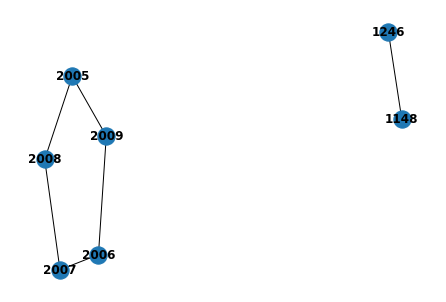

tensor([[2006, 2005, 2006, 2007, 2005, 1148],
        [2009, 2009, 2007, 2008, 2008, 1246]])
f1_score, ged 0.8333333333333334 4.0
[0.12051469 0.41694516 0.07163423 0.1895954  0.41694516 0.18146259
 0.07163423 0.1895954  0.10912126 0.18146259]


<Figure size 432x288 with 0 Axes>

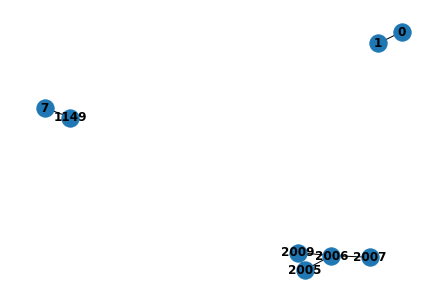

tensor([[2006, 2005, 2006, 2005,    0, 1149],
        [2009, 2009, 2007, 2006,    1,    7]])
f1_score, ged 0.6666666666666666 7.0
[0.02603137 0.00718439 0.46472955 0.23338819 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

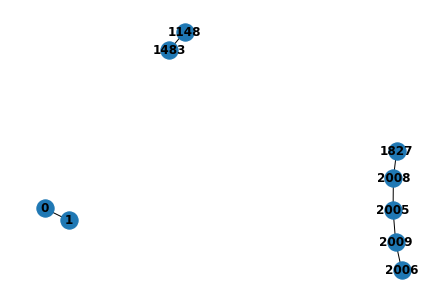

tensor([[2006, 2005, 1827, 2005,    0, 1148],
        [2009, 2009, 2008, 2008,    1, 1483]])
f1_score, ged 0.5 8.0
[0.01272047 0.00222707 0.00063252 0.00063252 0.00029409 0.00203836
 0.00135851 0.00164139 0.00164139 0.05118978 0.05576301 0.154006
 0.01026452 0.03008842 0.154006   0.05576301 0.01026452 0.03008842
 0.05576301]


<Figure size 432x288 with 0 Axes>

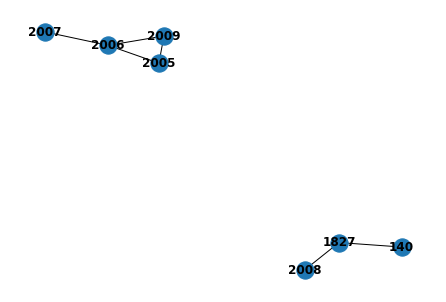

tensor([[2006, 2005, 2005, 1827, 2006,  140],
        [2009, 2009, 2006, 2008, 2007, 1827]])
f1_score, ged 0.6666666666666666 6.0
[0.03252065 0.02846277 0.49933362 0.14103723 0.2866776  0.103526
 0.02269602 0.02846277 0.14103723 0.2866776  0.14032996 0.02269602]


<Figure size 432x288 with 0 Axes>

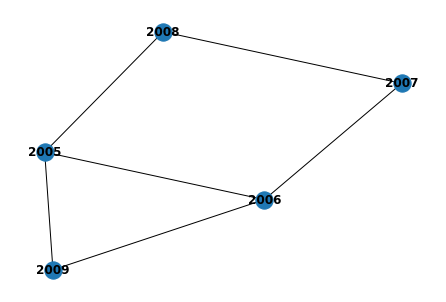

tensor([[2005, 2006, 2006, 2005, 2007, 2005],
        [2009, 2007, 2009, 2006, 2008, 2008]])
f1_score, ged 1.0 0.0
[0.07163423 0.1895954  0.41694516 0.12051469 0.41694516 0.07163423
 0.1895954  0.18146259 0.18146259 0.10912126]


<Figure size 432x288 with 0 Axes>

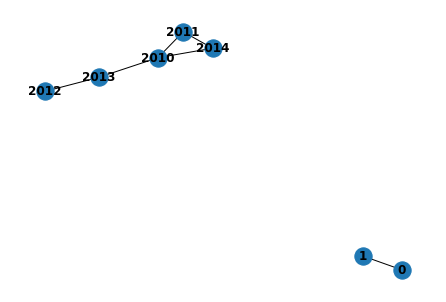

tensor([[2010, 2011, 2010, 2012, 2010,    0],
        [2014, 2014, 2013, 2013, 2011,    1]])
f1_score, ged 0.8333333333333334 4.0
[0.17534226 0.18984991 0.4204604  0.01549125 0.4204604  0.34293252
 0.18984991 0.05009085 0.4264254 ]


<Figure size 432x288 with 0 Axes>

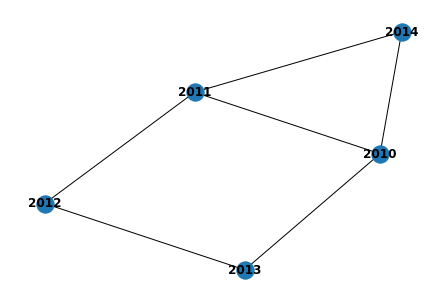

tensor([[2010, 2011, 2010, 2012, 2010, 2011],
        [2014, 2014, 2013, 2013, 2011, 2012]])
f1_score, ged 1.0 0.0
[1.03420019e-02 9.20665264e-03 2.82919407e-03 7.63416290e-04
 9.97781754e-05 1.35302544e-04 5.19633293e-04 7.36594200e-04
 1.16193295e-03 7.75719881e-02 8.66246223e-03 2.57548094e-02
 1.64820671e-01 5.59939146e-02 1.64820671e-01 8.66246223e-03
 2.57548094e-02 5.59939146e-02 5.59473038e-03 5.59939146e-02]


<Figure size 432x288 with 0 Axes>

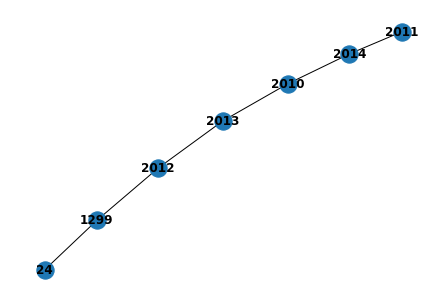

tensor([[2011, 2010, 1299, 2012, 2010,   24],
        [2014, 2014, 2012, 2013, 2013, 1299]])
f1_score, ged 0.6666666666666666 6.0
[0.02603137 0.23338819 0.46472955 0.00718439 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

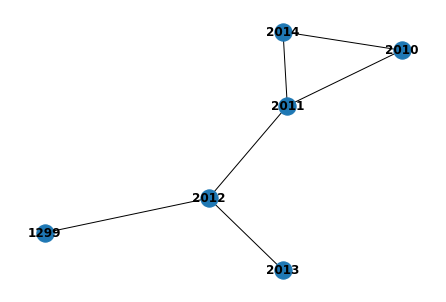

tensor([[2012, 2010, 2011, 2010, 1299, 2011],
        [2013, 2014, 2014, 2011, 2012, 2012]])
f1_score, ged 0.8333333333333334 3.0
[0.14103723 0.2866776  0.103526   0.03252065 0.02846277 0.49933362
 0.14103723 0.2866776  0.02269602 0.02846277 0.02269602 0.14032996]


<Figure size 432x288 with 0 Axes>

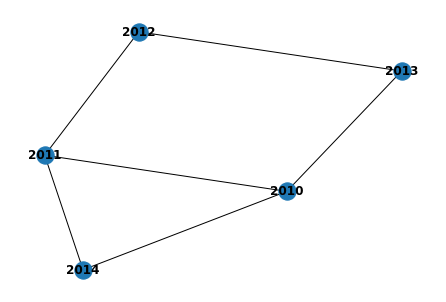

tensor([[2011, 2010, 2012, 2010, 2010, 2011],
        [2014, 2013, 2013, 2011, 2014, 2012]])
f1_score, ged 1.0 0.0
[0.07163423 0.1895954  0.41694516 0.12051469 0.41694516 0.07163423
 0.1895954  0.18146259 0.18146259 0.10912126]


<Figure size 432x288 with 0 Axes>

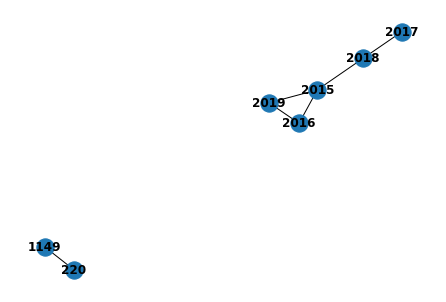

tensor([[2016, 2015, 2015, 2017, 2015, 1149],
        [2019, 2019, 2018, 2018, 2016,  220]])
f1_score, ged 0.8333333333333334 4.0
[0.17534226 0.18984991 0.4204604  0.01549125 0.4204604  0.34293252
 0.18984991 0.05009085 0.4264254 ]


<Figure size 432x288 with 0 Axes>

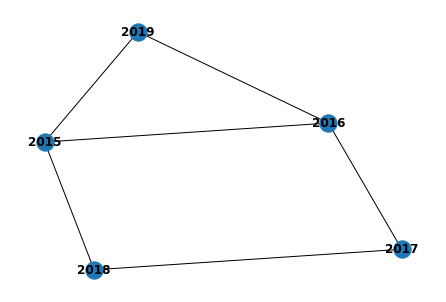

tensor([[2015, 2016, 2015, 2017, 2015, 2016],
        [2019, 2019, 2018, 2018, 2016, 2017]])
f1_score, ged 1.0 0.0
[1.22464895e-02 4.41122055e-03 7.96675682e-04 5.62334061e-03
 5.66244125e-05 3.92079353e-04 1.16348267e-03 7.37428665e-04
 3.09109688e-04 7.73830414e-02 8.67474079e-03 2.57881880e-02
 1.64734364e-01 5.59912920e-02 1.64734364e-01 8.67474079e-03
 2.57881880e-02 5.59912920e-02 5.47087193e-03 5.59912920e-02]


<Figure size 432x288 with 0 Axes>

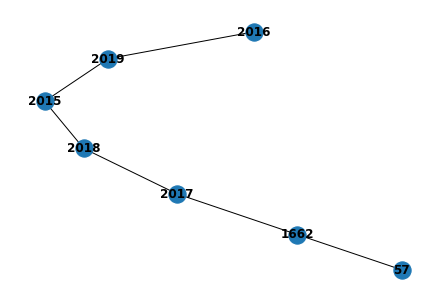

tensor([[2015, 2016, 1662, 2015, 2017,   57],
        [2019, 2019, 2017, 2018, 2018, 1662]])
f1_score, ged 0.6666666666666666 6.0
[0.02603137 0.23338819 0.46472955 0.00718439 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [33]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_occlusion(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [144]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.8166666666666668 3.55 0.8166666666666668 0.8166666666666668


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Node_Explainer:
    def __init__(
            self,
            model,
            edge_index,
            X,
            num_layers,
            mode=0,
            print_result=1
    ):
        self.model = model
        self.model.eval()
        self.edge_index = edge_index
        self.X = X
        self.num_layers = num_layers
        self.mode = mode
        self.print_result = print_result

    def perturb_features_on_node(self, feature_matrix, node_idx, random=0, mode=0):
        # return a random perturbed feature matrix
        # random = 0 for nothing, 1 for random.
        # mode = 0 for random 0-1, 1 for scaling with original feature

        X_perturb = feature_matrix
        if mode == 0:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.random.randint(2, size=X_perturb[node_idx].shape[0])
            X_perturb[node_idx] = perturb_array
        elif mode == 1:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.multiply(X_perturb[node_idx],
                                            np.random.uniform(low=0.0, high=2.0, size=X_perturb[node_idx].shape[0]))
            X_perturb[node_idx] = perturb_array
        return X_perturb

    def explain(self, node_idx, target, num_samples=100, top_node=None, p_threshold=0.05, pred_threshold=0.1):
        neighbors, _, _, _ = k_hop_subgraph(node_idx, self.num_layers, self.edge_index)
        neighbors = neighbors.cpu().detach().numpy()

        if (node_idx not in neighbors):
            neighbors = np.append(neighbors, node_idx)

        pred_torch = self.model(self.X, self.edge_index).cpu()
        soft_pred = np.asarray([softmax(np.asarray(pred_torch[node_].data)) for node_ in range(self.X.shape[0])])

        pred_node = np.asarray(pred_torch[node_idx].data)
        label_node = np.argmax(pred_node)
        soft_pred_node = softmax(pred_node)

        Samples = []
        Pred_Samples = []

        for iteration in range(num_samples):

            X_perturb = self.X.cpu().detach().numpy()
            sample = []
            for node in neighbors:
                seed = np.random.randint(2)
                if seed == 1:
                    latent = 1
                    X_perturb = self.perturb_features_on_node(X_perturb, node, random=seed)
                else:
                    latent = 0
                sample.append(latent)

            X_perturb_torch = torch.tensor(X_perturb, dtype=torch.float).to(device)
            pred_perturb_torch = self.model(X_perturb_torch, self.edge_index).cpu()
            soft_pred_perturb = np.asarray(
                [softmax(np.asarray(pred_perturb_torch[node_].data)) for node_ in range(self.X.shape[0])])

            sample_bool = []
            for node in neighbors:
                if (soft_pred_perturb[node, target] + pred_threshold) < soft_pred[node, target]:
                    sample_bool.append(1)
                else:
                    sample_bool.append(0)

            Samples.append(sample)
            Pred_Samples.append(sample_bool)

        Samples = np.asarray(Samples)
        Pred_Samples = np.asarray(Pred_Samples)
        Combine_Samples = Samples - Samples
        for s in range(Samples.shape[0]):
            Combine_Samples[s] = np.asarray(
                [Samples[s, i] * 10 + Pred_Samples[s, i] + 1 for i in range(Samples.shape[1])])

        data_pgm = pd.DataFrame(Combine_Samples)
        data_pgm = data_pgm.rename(columns={0: 'A', 1: 'B'})  # Trick to use chi_square test on first two data columns
        ind_ori_to_sub = dict(zip(neighbors, list(data_pgm.columns)))

        p_values = []
        for node in neighbors:
            if node == node_idx:
                p = 0 # p<0.05 => we are confident that we can reject the null hypothesis (i.e. the prediction is the same after perturbing the neighbouring node 
                # => this neighbour has no influence on the prediction - should not be in the explanation)
            else:
                chi2, p,_ = chi_square(ind_ori_to_sub[node], ind_ori_to_sub[node_idx], [], data_pgm, boolean=False, significance_level=0.05)
            p_values.append(p)

        pgm_stats = dict(zip(neighbors, p_values))
        return pgm_stats

In [35]:
def explain_pgmexplainer(model, node_idx, x, edge_index, target, include_edges=None):
    explainer = Node_Explainer(model, edge_index, x, model.num_layers, print_result=0)
    explanation = explainer.explain(node_idx,target)
    node_attr = np.zeros(x.shape[0])
    for node, p_value in explanation.items():
        node_attr[node] = 1 - p_value
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

[0.51875682 0.51875682 0.51875682 0.51875682 0.51875682 0.51875682
 0.51875682 0.51875682 0.51875682 0.51875682 1.51875682 2.
 2.         1.99999999 2.         2.         1.99999999 2.
 2.         1.51875682 2.         2.         1.99999999 1.99999999]


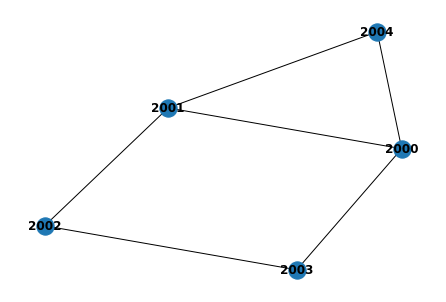

tensor([[2002, 2000, 2000, 2001, 2000, 2001],
        [2003, 2001, 2003, 2002, 2004, 2004]])
f1_score, ged 1.0 0.0
[0.49364384 1.0320932  0.52573704 0.55257066 1.0320932  1.52047746
 1.52047746 1.52047746 1.0141213  0.49364384 0.52573704 1.0141213
 0.55257066 1.52047746]


<Figure size 432x288 with 0 Axes>

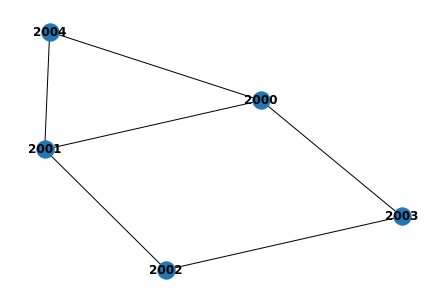

tensor([[2001, 2001, 2000, 2002, 2000, 2000],
        [2002, 2004, 2001, 2003, 2004, 2003]])
f1_score, ged 1.0 0.0
[0.045138   0.045138   0.045138   0.045138   0.045138   0.045138
 0.045138   0.045138   0.045138   0.045138   0.27226293 0.13793456
 0.22712493 0.35943989 0.13793456 1.13793456 0.49737445 1.13793456
 1.22712493 0.27226293 0.22712493 1.22712493 0.35943989 0.49737445]


<Figure size 432x288 with 0 Axes>

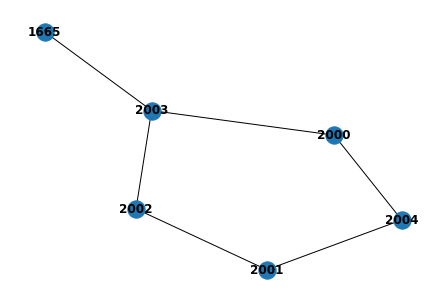

tensor([[2002, 2001, 2001, 2000, 1665, 2000],
        [2003, 2002, 2004, 2004, 2003, 2003]])
f1_score, ged 0.8333333333333334 3.0
[0.5786205  0.5786205  0.17502635 0.17502635 0.5786205  0.26998959
 0.28272525 0.5786205  0.28272525 0.90097158 0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.84861009 0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.90097158 0.28272525 0.28272525
 0.5786205  0.17502635 0.5786205  0.5786205  0.17502635 0.5786205
 0.5786205  0.90097158 0.5786205  0.5786205  0.17502635 0.5786205
 0.5786205  0.28272525 0.28272525 0.28272525 0.28272525 0.28272525
 0.28272525 0.28272525 0.55271484 0.17502635 0.17502635 0.17502635
 0.17502635 0.17502635 0.17502635 0.44501594 0.90097158 0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.90097158
 0.9009

<Figure size 432x288 with 0 Axes>

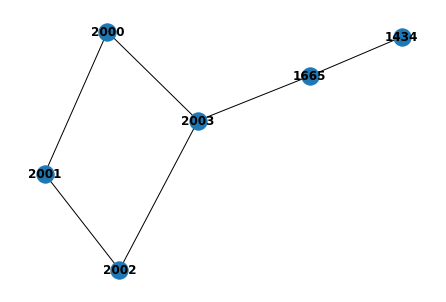

tensor([[2002, 2000, 1665, 1434, 2001, 2000],
        [2003, 2003, 2003, 1665, 2002, 2001]])
f1_score, ged 0.6666666666666666 3.0
[0.14941887 0.44898409 0.14941887 1.         0.44898409 0.88035944
 1.44898409 0.88035944 0.58079422 0.14941887 0.14941887 0.58079422
 1.         1.44898409]


<Figure size 432x288 with 0 Axes>

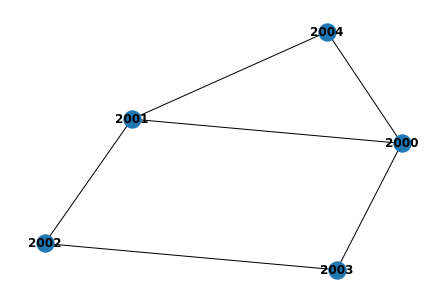

tensor([[2001, 2000, 2001, 2002, 2000, 2000],
        [2004, 2004, 2002, 2003, 2001, 2003]])
f1_score, ged 1.0 0.0
[0.59363772 0.59363772 0.59363772 0.59363772 0.59363772 0.59363772
 0.59363772 0.59363772 0.59363772 0.59363772 1.59363772 2.
 2.         1.99960565 2.         2.         1.99960565 2.
 2.         1.59363772 2.         2.         1.99960565 1.99960565]


<Figure size 432x288 with 0 Axes>

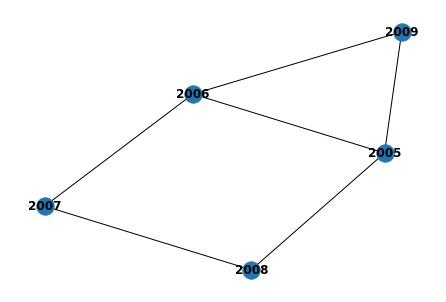

tensor([[2005, 2005, 2006, 2007, 2006, 2005],
        [2008, 2006, 2007, 2008, 2009, 2009]])
f1_score, ged 1.0 0.0


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [36]:
import time 


list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_pgmexplainer(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [ ]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision), np.mean(duration_samples))

In [80]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision), np.mean(duration_samples))

0.7497902097902097 1.65 0.7249999999999999 0.785357142857143 nan


/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [44]:
def explain_random(model, node_idx, x, edge_index, target, include_edges=None):
    return np.random.uniform(size=edge_index.shape[1])

[0.29218136 0.15195296 0.23682181 ... 0.65071381 0.36042914 0.02769381]


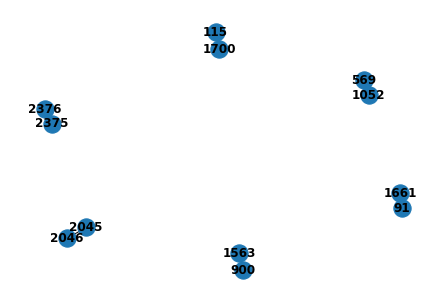

tensor([[2375,   91,  900,  569, 2045,  115],
        [2376, 1661, 1563, 1052, 2046, 1700]])
f1_score, ged 0 15.0
[0.25748322 0.55452075 0.77116991 ... 0.08410639 0.46548574 0.58332501]


<Figure size 432x288 with 0 Axes>

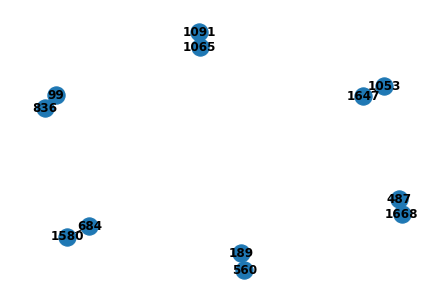

tensor([[  99,  684, 1065, 1053,  189,  487],
        [ 836, 1580, 1091, 1647,  560, 1668]])
f1_score, ged 0 15.0
[0.29058395 0.18983893 0.99145235 ... 0.82166589 0.00548186 0.03905489]


<Figure size 432x288 with 0 Axes>

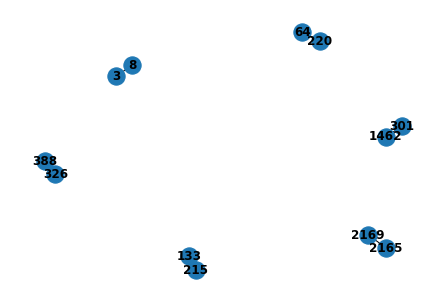

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [45]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_random(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [46]:
def explain_distance(model, node_idx, x, edge_index, target, include_edges=None):
    data = Data(x=x, edge_index=edge_index)
    g = to_networkx(data)
    length = nx.shortest_path_length(g, target=node_idx)

    def get_attr(node):
        if node in length:
            return 1 / (length[node] + 1)
        return 0

    edge_sources = edge_index[1].cpu().numpy()
    return np.array([get_attr(node) for node in edge_sources])

[0.16666667 0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


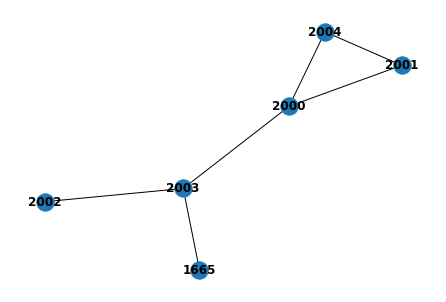

tensor([[1665, 2002, 2000, 2001, 2000, 2000],
        [2003, 2003, 2004, 2004, 2003, 2001]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

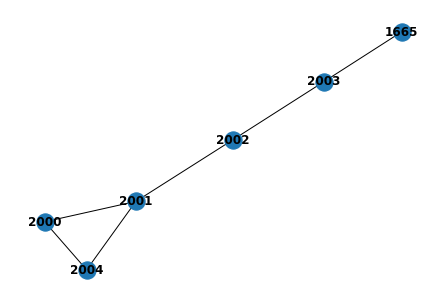

tensor([[2000, 2000, 2001, 2001, 1665, 2002],
        [2001, 2004, 2004, 2002, 2003, 2003]])
f1_score, ged 0.8333333333333334 3.0
[0.16666667 0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

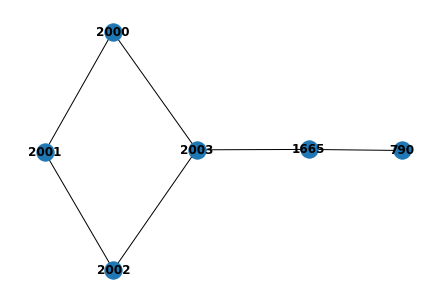

tensor([[2001, 1665, 2002, 2000, 2000,  790],
        [2002, 2003, 2003, 2003, 2001, 1665]])
f1_score, ged 0.6666666666666666 3.0
[0.2        0.25       0.25       ... 0.125      0.16666667 0.14285714]


<Figure size 432x288 with 0 Axes>

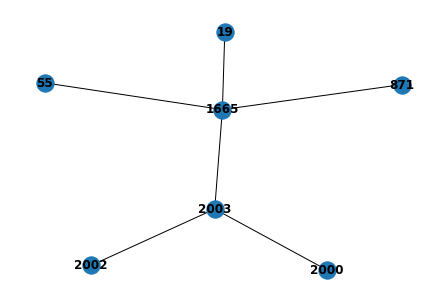

tensor([[1665, 2002, 2000,   55,   19,  871],
        [2003, 2003, 2003, 1665, 1665, 1665]])
f1_score, ged 0.3333333333333333 6.0
[0.14285714 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

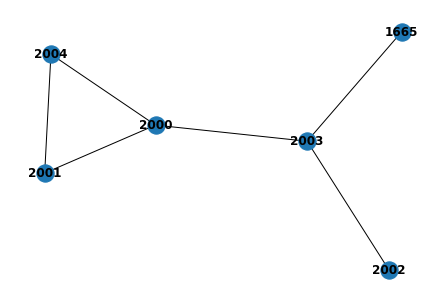

tensor([[2000, 2001, 2000, 1665, 2002, 2000],
        [2004, 2004, 2001, 2003, 2003, 2003]])
f1_score, ged 0.8333333333333334 3.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

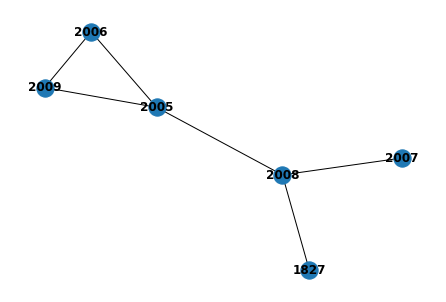

tensor([[2005, 1827, 2007, 2006, 2005, 2005],
        [2006, 2008, 2008, 2009, 2009, 2008]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

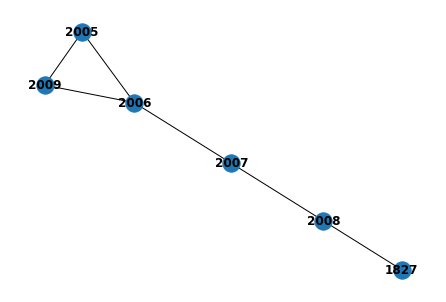

tensor([[2005, 2006, 2006, 2005, 1827, 2007],
        [2006, 2009, 2007, 2009, 2008, 2008]])
f1_score, ged 0.8333333333333334 3.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

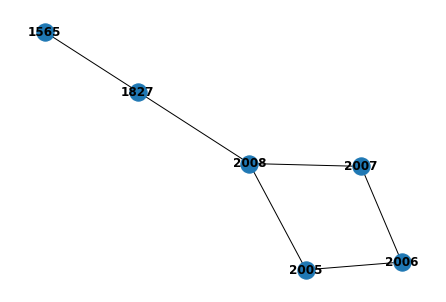

tensor([[2006, 2005, 1827, 2007, 2005, 1565],
        [2007, 2006, 2008, 2008, 2008, 1827]])
f1_score, ged 0.6666666666666666 3.0
[0.2        0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

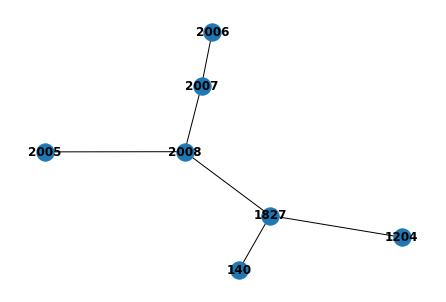

tensor([[2005, 1827, 2007,  140, 1204, 2006],
        [2008, 2008, 2008, 1827, 1827, 2007]])
f1_score, ged 0.5 6.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

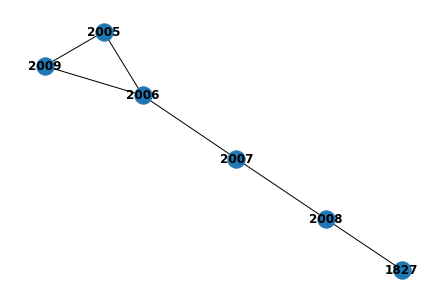

tensor([[2006, 2005, 2005, 1827, 2007, 2006],
        [2009, 2009, 2006, 2008, 2008, 2007]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

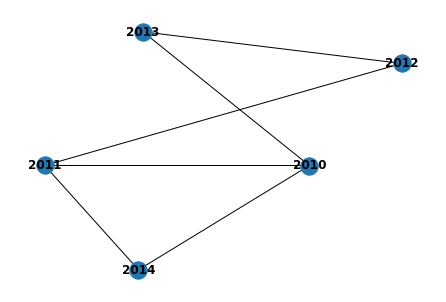

tensor([[2010, 2010, 2011, 2012, 2010, 2011],
        [2013, 2014, 2014, 2013, 2011, 2012]])
f1_score, ged 1.0 0.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

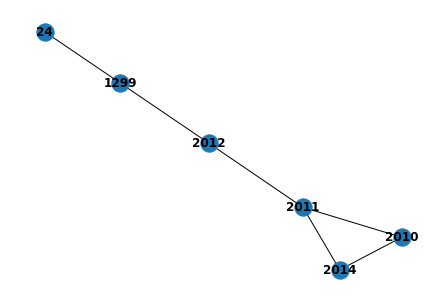

tensor([[2010, 2010, 2011, 2011, 1299,   24],
        [2011, 2014, 2012, 2014, 2012, 1299]])
f1_score, ged 0.6666666666666666 3.0
[0.2        0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

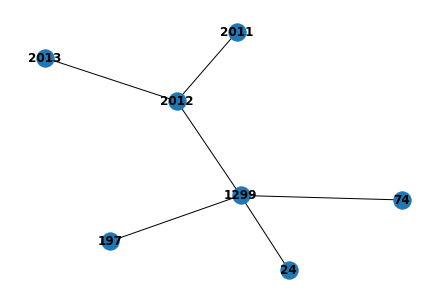

tensor([[2011, 1299,   24, 2012,  197,   74],
        [2012, 2012, 1299, 2013, 1299, 1299]])
f1_score, ged 0.3333333333333333 6.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

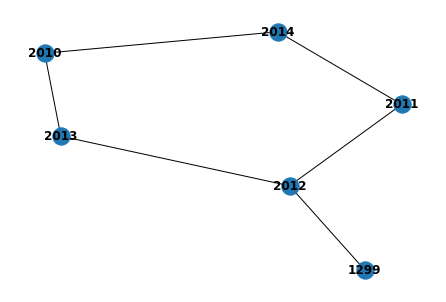

tensor([[2010, 2012, 2011, 1299, 2010, 2011],
        [2013, 2013, 2012, 2012, 2014, 2014]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

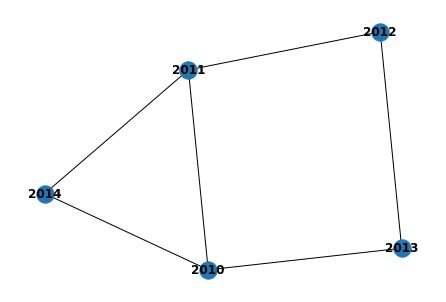

tensor([[2010, 2011, 2010, 2010, 2011, 2012],
        [2014, 2014, 2011, 2013, 2012, 2013]])
f1_score, ged 1.0 0.0
[0.16666667 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

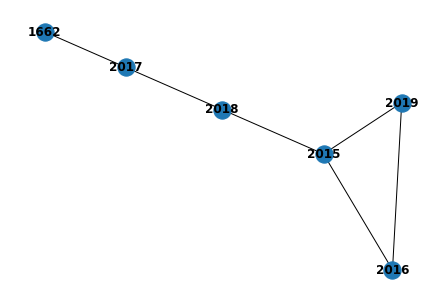

tensor([[2015, 2015, 2016, 2015, 2017, 1662],
        [2019, 2016, 2019, 2018, 2018, 2017]])
f1_score, ged 0.8333333333333334 3.0
[0.2        0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

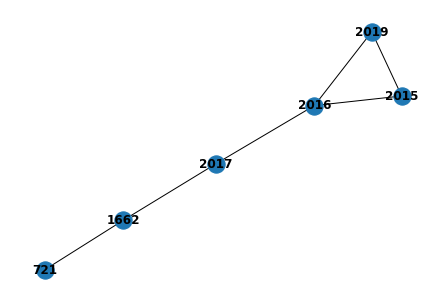

tensor([[2015, 2015, 1662, 2016, 2016,  721],
        [2016, 2019, 2017, 2017, 2019, 1662]])
f1_score, ged 0.6666666666666666 3.0
[0.25       0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

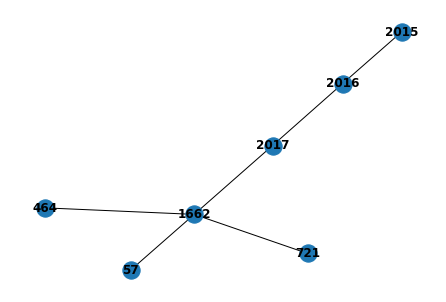

tensor([[2016, 1662,   57, 2015,  464,  721],
        [2017, 2017, 1662, 2016, 1662, 1662]])
f1_score, ged 0.3333333333333333 6.0
[0.2        0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

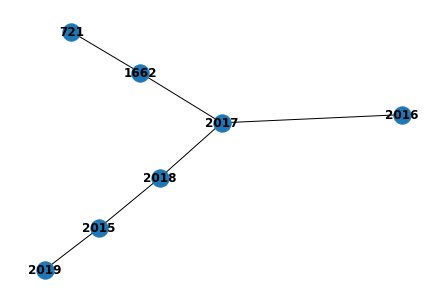

tensor([[2015, 2017, 1662, 2016, 2015,  721],
        [2018, 2018, 2017, 2017, 2019, 1662]])
f1_score, ged 0.6666666666666666 6.0
[0.16666667 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

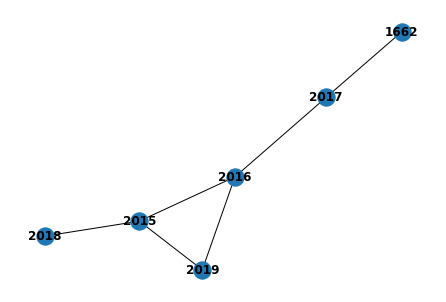

tensor([[2015, 2016, 2015, 1662, 2016, 2015],
        [2019, 2019, 2016, 2017, 2017, 2018]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

In [47]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_distance(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [48]:
def explain_pagerank(model, node_idx, x, edge_index, target, include_edges=None):
    data = Data(x=x, edge_index=edge_index)
    g = to_networkx(data)
    pagerank = nx.pagerank(g, personalization={node_idx: 1})

    node_attr = np.zeros(x.shape[0])
    for node, value in pagerank.items():
        node_attr[node] = value
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

[1.32453888e-03 1.69397530e-03 2.54784989e-03 ... 7.50785614e-06
 1.33518254e-05 9.68526597e-06]


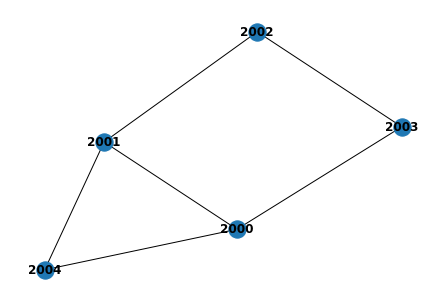

tensor([[2000, 2000, 2000, 2001, 2001, 2002],
        [2001, 2004, 2003, 2004, 2002, 2003]])
f1_score, ged 1.0 0.0
[1.11600353e-03 1.42445958e-03 2.13800134e-03 ... 6.95529024e-06
 1.20614140e-05 8.92237558e-06]


<Figure size 432x288 with 0 Axes>

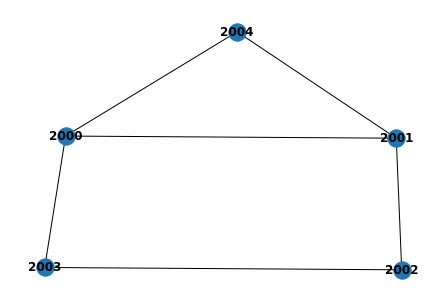

tensor([[2000, 2001, 2001, 2000, 2000, 2002],
        [2001, 2004, 2002, 2004, 2003, 2003]])
f1_score, ged 1.0 0.0
[1.53740046e-03 1.96925299e-03 2.96676362e-03 ... 8.06205697e-06
 1.46552188e-05 1.04518902e-05]


<Figure size 432x288 with 0 Axes>

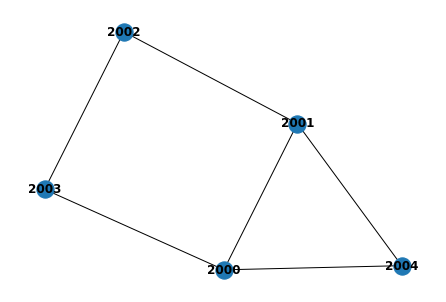

tensor([[2001, 2002, 2000, 2000, 2001, 2000],
        [2002, 2003, 2001, 2003, 2004, 2004]])
f1_score, ged 1.0 0.0
[2.48959870e-03 3.19737775e-03 4.83052295e-03 ... 1.13912594e-05
 2.15790659e-05 1.49084293e-05]


<Figure size 432x288 with 0 Axes>

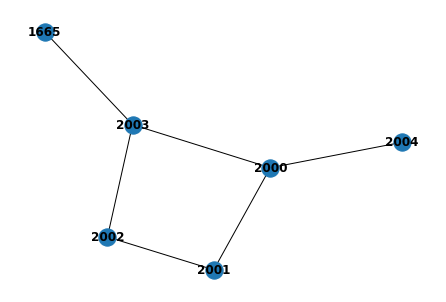

tensor([[2000, 2002, 1665, 2000, 2001, 2000],
        [2003, 2003, 2003, 2001, 2002, 2004]])
f1_score, ged 0.8333333333333334 3.0
[1.04618233e-03 1.33413151e-03 2.00045765e-03 ... 6.77583828e-06
 1.16372338e-05 8.67374532e-06]


<Figure size 432x288 with 0 Axes>

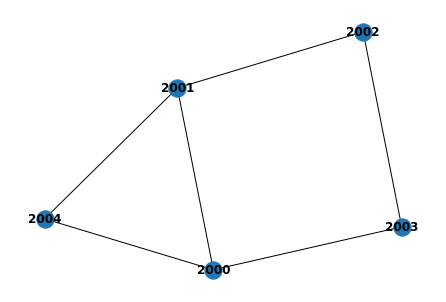

tensor([[2001, 2000, 2000, 2000, 2001, 2002],
        [2004, 2004, 2001, 2003, 2002, 2003]])
f1_score, ged 1.0 0.0
[1.10583891e-03 1.24979465e-03 1.44841009e-03 ... 7.34985856e-06
 1.29791515e-05 9.46644075e-06]


<Figure size 432x288 with 0 Axes>

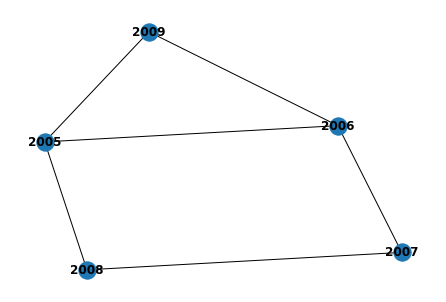

tensor([[2005, 2005, 2005, 2006, 2006, 2007],
        [2006, 2009, 2008, 2009, 2007, 2008]])
f1_score, ged 1.0 0.0
[9.25316400e-04 1.04567418e-03 1.21195350e-03 ... 6.11609110e-06
 1.08199168e-05 7.88050674e-06]


<Figure size 432x288 with 0 Axes>

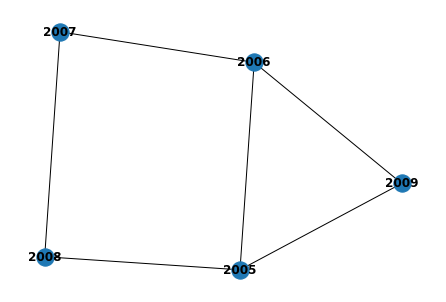

tensor([[2005, 2006, 2006, 2005, 2005, 2007],
        [2006, 2009, 2007, 2009, 2008, 2008]])
f1_score, ged 1.0 0.0
[1.28078357e-03 1.44828793e-03 1.67755761e-03 ... 7.87297539e-06
 1.42123585e-05 1.01904148e-05]


<Figure size 432x288 with 0 Axes>

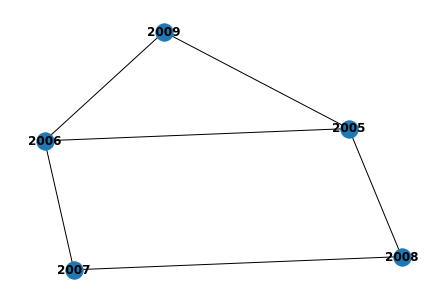

tensor([[2006, 2007, 2005, 2005, 2006, 2005],
        [2007, 2008, 2006, 2008, 2009, 2009]])
f1_score, ged 1.0 0.0
[2.06633050e-03 2.33872893e-03 2.70648849e-03 ... 1.10691951e-05
 2.08329554e-05 1.44643198e-05]


<Figure size 432x288 with 0 Axes>

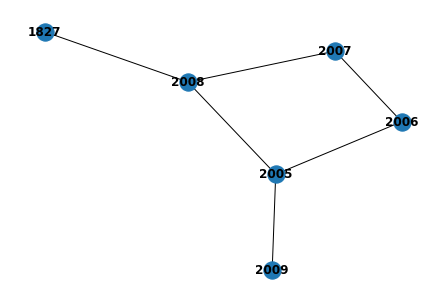

tensor([[2005, 2007, 1827, 2005, 2006, 2005],
        [2008, 2008, 2008, 2006, 2007, 2009]])
f1_score, ged 0.8333333333333334 3.0
[8.67691112e-04 9.80298783e-04 1.13647359e-03 ... 5.94188816e-06
 1.04109897e-05 7.63981236e-06]


<Figure size 432x288 with 0 Axes>

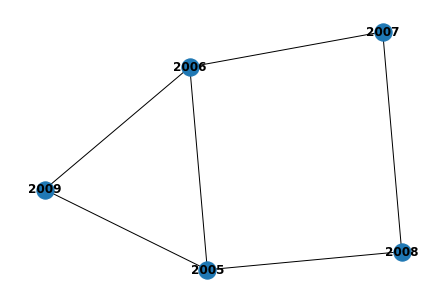

tensor([[2006, 2005, 2005, 2005, 2006, 2007],
        [2009, 2009, 2006, 2008, 2007, 2008]])
f1_score, ged 1.0 0.0
[1.65377137e-03 1.71813456e-03 1.90441342e-03 ... 6.74515672e-06
 1.15672815e-05 8.63167774e-06]


<Figure size 432x288 with 0 Axes>

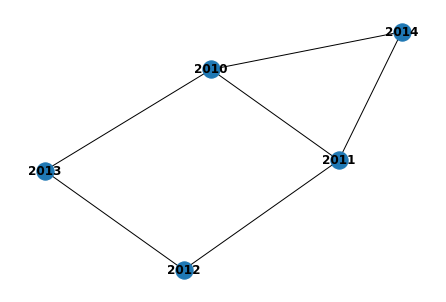

tensor([[2010, 2010, 2010, 2011, 2011, 2012],
        [2011, 2014, 2013, 2014, 2012, 2013]])
f1_score, ged 1.0 0.0
[1.97141972e-03 2.04737839e-03 2.26753949e-03 ... 7.24934231e-06
 1.27500628e-05 9.32854671e-06]


<Figure size 432x288 with 0 Axes>

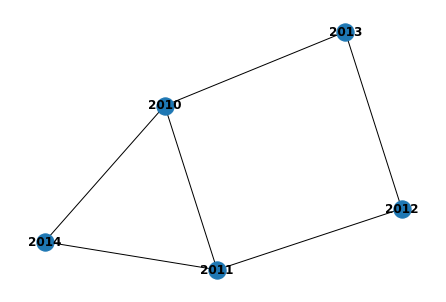

tensor([[2010, 2011, 2011, 2010, 2010, 2012],
        [2011, 2014, 2012, 2014, 2013, 2013]])
f1_score, ged 1.0 0.0
[3.73993962e-03 3.88100145e-03 4.29112664e-03 ... 1.08703802e-05
 2.03883470e-05 1.41929867e-05]


<Figure size 432x288 with 0 Axes>

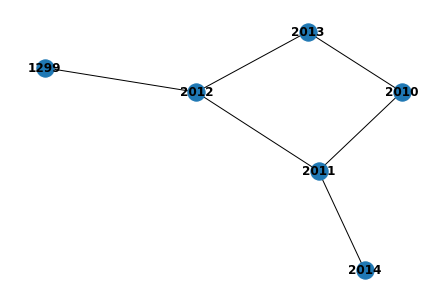

tensor([[2011, 2012, 1299, 2010, 2010, 2011],
        [2012, 2013, 2012, 2011, 2013, 2014]])
f1_score, ged 0.8333333333333334 3.0
[2.29608740e-03 2.38386118e-03 2.63856353e-03 ... 7.75403032e-06
 1.39431600e-05 1.00275987e-05]


<Figure size 432x288 with 0 Axes>

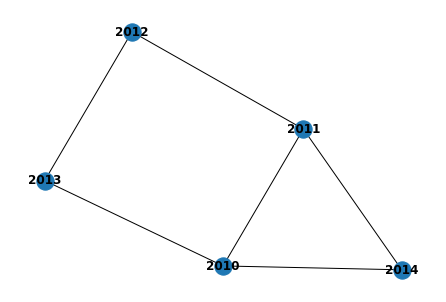

tensor([[2010, 2012, 2010, 2011, 2010, 2011],
        [2013, 2013, 2011, 2012, 2014, 2014]])
f1_score, ged 1.0 0.0
[1.54718860e-03 1.60768123e-03 1.78263570e-03 ... 6.58197222e-06
 1.11793901e-05 8.40524271e-06]


<Figure size 432x288 with 0 Axes>

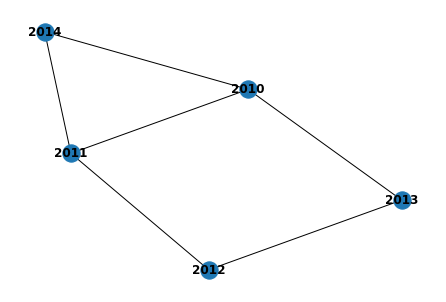

tensor([[2010, 2011, 2010, 2011, 2010, 2012],
        [2014, 2014, 2011, 2012, 2013, 2013]])
f1_score, ged 1.0 0.0
[1.06842299e-03 1.07464209e-03 1.30528532e-03 ... 7.04286122e-06
 1.22708800e-05 9.04436303e-06]


<Figure size 432x288 with 0 Axes>

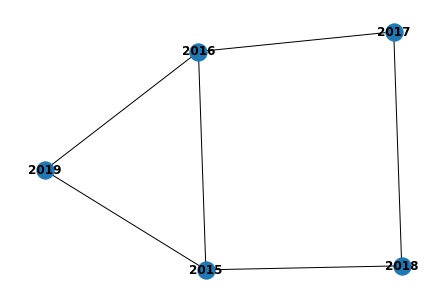

tensor([[2015, 2015, 2015, 2016, 2016, 2017],
        [2016, 2019, 2018, 2019, 2017, 2018]])
f1_score, ged 1.0 0.0
[1.26726652e-03 1.27334980e-03 1.54683762e-03 ... 7.61664186e-06
 1.36094772e-05 9.83570713e-06]


<Figure size 432x288 with 0 Axes>

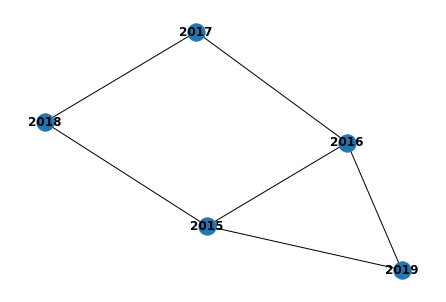

tensor([[2015, 2016, 2016, 2015, 2015, 2017],
        [2016, 2019, 2017, 2019, 2018, 2018]])
f1_score, ged 1.0 0.0
[2.37870386e-03 2.38496700e-03 2.89791356e-03 ... 1.16142031e-05
 2.20951259e-05 1.52149286e-05]


<Figure size 432x288 with 0 Axes>

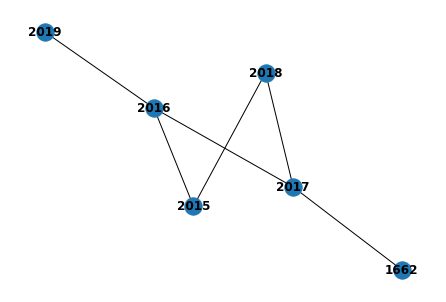

tensor([[2016, 2017, 1662, 2015, 2015, 2016],
        [2017, 2018, 2017, 2016, 2018, 2019]])
f1_score, ged 0.8333333333333334 3.0
[1.47018725e-03 1.47606849e-03 1.79326152e-03 ... 8.19252175e-06
 1.49616176e-05 1.06318333e-05]


<Figure size 432x288 with 0 Axes>

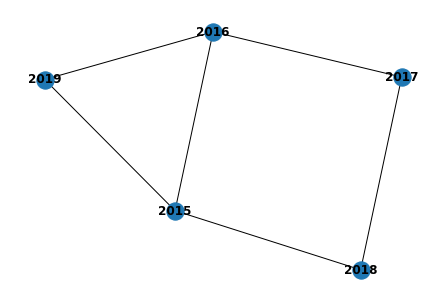

tensor([[2015, 2017, 2015, 2016, 2015, 2016],
        [2018, 2018, 2016, 2017, 2019, 2019]])
f1_score, ged 1.0 0.0
[1.00187901e-03 1.00817722e-03 1.22450018e-03 ... 6.85628102e-06
 1.18311067e-05 8.78573719e-06]


<Figure size 432x288 with 0 Axes>

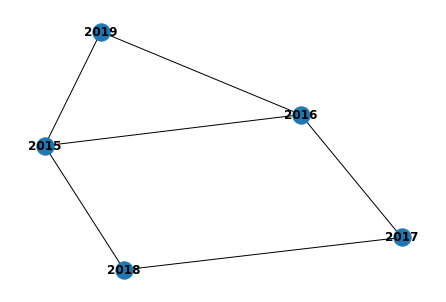

tensor([[2015, 2016, 2015, 2016, 2015, 2017],
        [2019, 2019, 2016, 2017, 2018, 2018]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

In [49]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_pagerank(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [50]:
def get_all_convolution_layers(model):
    layers = []
    for module in model.modules():
        if isinstance(module, MessagePassing):
            layers.append(module)
    return layers

In [51]:
def explain_gradXact(model, node_idx, x, edge_index, target, include_edges=None):
    # Captum default implementation of LayerGradCam does not average over nodes for different channels because of
    # different assumptions on tensor shapes
    input_mask = x.clone().requires_grad_(True).to(device)
    layers = get_all_convolution_layers(model)
    node_attrs = []
    for layer in layers:
        layer_gc = LayerGradCam(model_forward_node, layer)
        node_attr = layer_gc.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx))
        node_attr = node_attr.cpu().detach().numpy().ravel()
        node_attrs.append(node_attr)
    node_attr = np.array(node_attrs).mean(axis=0)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [1]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_gradXact(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

NameError: name 'n_basis' is not defined